Importing all the modules. Some may not be needed as of now. 

In [1]:
# modules - probably too many
import numpy as np
import pandas as pd
import pickle
import matplotlib
import scipy
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text
from sklearn import neighbors
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import matplotlib.colors as colors
from scipy import stats
pd.options.mode.chained_assignment = None  # default='warn'
import math
import seaborn as sns
import multiprocessing
import numpy.matlib as npm
import geeadd
import ee
import mlLocal
from importlib import reload
import geemap

In [2]:
#code the input feature domain by using a linear hash for each row of the input data frame
#the hash algorithm converts each input row into an integer from 0 to 9 by applying the provided scale and offset and then rounding
#is then produces a hash entry for each row by packing the integers consequitively to form a uint64 code
#this implies a limit of at most 18 columns for the input data frame
#returns a list corresonding to hash table of unique coded input rows
def makeDomain(df,domainIndex,domainScaling,domainOffset):
    df = np.array(df) 
    if df.shape[1] < 19 :
        domainIndex = np.array(domainIndex)
        domainScaling = np.array(domainScaling)
        domainOffset = np.array(domainOffset)
    else:
        raise ValueError("More than 18 dimensions in domain")
    return np.uint64(np.unique(np.sum(np.clip(np.around(df* domainScaling + domainOffset,0),0,9) * np.power(10,np.cumsum(domainIndex)-domainIndex[0]),1),0)).tolist()
          

In [3]:
def trainClassifier(dataDict,regressorsNames,regressorsGEENames, response, domainScaling,domainOffset,samplingFeatures=None,minSubSamples=2000,minSatSamples=-1,maxSamples=10000,percentilePairwiseDist=99,maxleafnodesParent= 1, minSamplesLeafParent=100, maxleafnodesChild= 999, minSamplesLeafChild=10,maxFeatures="auto",nTrees = 100):
    
    
    # make generic names for regressors for use in GEE
    regressors = []
    for item in np.arange(1,len(regressorsNames)+1,1):
        regressors.append('x' + str(item))

    # Calibrate hierarchal randforest preeidctors for each biome
    for biome in dataDict.keys():
        print('biome:',biome)

        if ( biome <10):
            # subset only the regressors and response 
            dfBiome = dataDict[biome]['DF'][sum([regressorsNames,response],[])].astype('int')

            
            # resample the data for calibrating parent tree
            if ( samplingFeatures != None ) :
                dfParent = resampleDF(dfBiome ,regressorsNames,samplingFeatures,minSubSamples=minSubSamples,minSatSamples=minSatSamples,maxSamples=maxSamples,percentilePairwiseDist=percentilePairwiseDist)
                print('subsampled',dfParent.shape)

                dfParent = resampleDF(dfParent,regressorsName,features,minSubSamples,minSubSamples=minSubSamples,minSatSamples=minSatSamples,maxSamples=maxSamples,percentilePairwiseDist=50)
            else :
                dfParent = dfBiome
                
            dfBiome.columns = sum([regressors,response],[])
            dfParent.columns = sum([regressors,response],[])
            print(dfBiome.shape)
            print(dfParent.shape)
             # populate a parent RF dictionary that holds a single tree RF used to partition data into child RFs
            parentRFDict = {}
            parentRFDict.update({'regressors': regressors})
            parentRFDict.update({'regressorsGEE': regressorsGEENames})
            parentRFDict.update({'response': response})
            parentRFDict.update({'domain':makeDomain(dfBiome[regressors],domainIndex,domainScaling,domainOffset)})
            parentRFDict.update({'RF': RandomForestRegressor(n_estimators=1,min_samples_leaf=minSamplesLeafParent,min_samples_split=int(dfParent.shape[0]*0.1),bootstrap=False,random_state=0,verbose=0,max_depth=10,max_leaf_nodes=maxleafnodesParent,max_features=maxFeatures,n_jobs=40) \
                                                                                                         .fit(dfParent[regressors], np.array(dfParent[response]).ravel())})       
            
            # label input data using the prediction from the parent RF as this will be unique
            dfBiome['estimate']=np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)

            # populate dictionary of children RFs, each childRF is itself a dictionary similar to the parentRF but now using more than one tree
            # each child is labelled using the prediction value from the parentRF corresponding to its partition
            childrenRFDict = {}
            print('number children:',np.unique(np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)).size)
            for partition in np.unique(np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)):
                dfpartitionBiome = dfBiome.loc[dfBiome['estimate'] == partition]
                childRFDict = {}
                childRFDict.update({'size': dfpartitionBiome[response].shape[0]})
                childRFDict.update({'regressors': regressors})
                childRFDict.update({'regressorsGEE': regressorsGEENames})
                childRFDict.update({'response': response})
                childRFDict.update({'domain':makeDomain(dfpartitionBiome[regressors],domainIndex,domainScaling,domainOffset)})
                childRFDict.update({'RF': RandomForestRegressor(n_estimators=nTrees,min_samples_leaf=minSamplesLeafChild,bootstrap=True,random_state=0,verbose=0,max_depth=9,max_leaf_nodes=maxleafnodesChild,max_features=maxFeatures,n_jobs=40) \
                                         .fit(dfpartitionBiome[regressors], np.array(dfpartitionBiome[response]).ravel())})             
                childrenRFDict.update({partition: childRFDict})

            # assign the childrenRFDict to the parent
            parentRFDict.update({'childrenRFDict':childrenRFDict })      

            #assign the parentRF dict to the calibration data dictionary for trhis biome
            dataDict[biome].update({method+response[0]+'parentRFDict':parentRFDict})   
    return dataDict

In [4]:
# apply algorithm to data 
def predictClassifier(dataDict,methodDict, method, regressorsNames, response):
    # make generic names for regressors for use in GEE
    regressors = []
    for item in np.arange(1,len(regressorsNames)+1,1):
        regressors.append('x' + str(item))

    # Calibrate hierarchal randforest preeidctors for each biome
    for biome in dataDict.keys():
        print('biome:',biome)

        if ( biome <9):
            # subset only the regressors 
            dfBiome = dataDict[biome]['DF'][sum([regressorsNames],[])].astype('int')
            dfBiome.columns = regressors

            #apply the parent classifier
            parentRF = methodDict[biome][method+response[0]+'parentRFDict']['RF']
            dfBiome['childNames'] =  np.around(parentRF.predict(dfBiome),decimals=3)
            dataDict[biome]['DF'][method + response[0]+'childNames'] =dfBiome['childNames']

            for partition in np.unique(dfBiome['childNames'] ):
                dfBiome.loc[dfBiome['childNames']==partition,method + response[0]] = methodDict[biome][method+response[0]+'parentRFDict']['childrenRFDict'][partition]['RF'].predict(dfBiome.loc[dfBiome['childNames']==partition][regressors])  
            dataDict[biome]['DF'][method + response[0]] = dfBiome[method + response[0]]
           
    return dataDict

In [5]:
def hierarchicalRF(dataDictParent,dataDictChild,regressorsNames,regressorsGEENames, response, domainScaling,domainOffset, maxDepth=20, minSamplesSplit=11,maxleafnodesParent= 100, minSamplesLeafParent=10, maxleafnodesChild= 999, minSamplesLeafChild=10,maxFeatures="auto",nTrees = 100):
    
    
    # make generic names for regressors for use in GEE
    regressors = []
    for item in np.arange(1,len(regressorsNames)+1,1):
        regressors.append('x' + str(item))

    # Calibrate hierarchal randforest preeidctors for each biome
    for biome in dataDictParent.keys():
        print('biome:',biome)

        # subset only the regressors and response 
        dfBiome = dataDictChild[biome]['DF'][sum([regressorsNames,response],[])].astype('int')   
        dfParent = dataDictParent[biome]['DF'][sum([regressorsNames,response],[])].astype('int')


        dfBiome.columns = sum([regressors,response],[])
        dfParent.columns = sum([regressors,response],[])
        print('Total size ',dfBiome.shape)
        print('Parent size ',dfParent.shape)
         # populate a parent RF dictionary that holds a single tree RF used to partition data into child RFs
        parentRFDict = {}
        parentRFDict.update({'regressors': regressors})
        parentRFDict.update({'regressorsGEE': regressorsGEENames})
        parentRFDict.update({'response': response})
        parentRFDict.update({'domain':makeDomain(dfBiome[regressors],domainIndex,domainScaling,domainOffset)})
        parentRFDict.update({'RF': RandomForestRegressor(n_estimators=1,min_samples_leaf=minSamplesLeafParent,min_samples_split=minSamplesSplit,bootstrap=False,random_state=0,verbose=0,max_depth=maxDepth,max_leaf_nodes=maxleafnodesParent,max_features=maxFeatures,n_jobs=40) \
                                                                                                         .fit(dfParent[regressors], np.array(dfParent[response]).ravel())})         
        # label input data using the prediction from the parent RF as this will be unique
        dfBiome['estimate']=np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)

        # populate dictionary of children RFs, each childRF is itself a dictionary similar to the parentRF but now using more than one tree
        # each child is labelled using the prediction value from the parentRF corresponding to its partition
        childrenRFDict = {}
        print('number children:',np.unique(np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)).size)
        for partition in np.unique(np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)):
            dfpartitionBiome = dfBiome.loc[dfBiome['estimate'] == partition]
            childRFDict = {}
            childRFDict.update({'size': dfpartitionBiome[response].shape[0]})
            childRFDict.update({'regressors': regressors})
            childRFDict.update({'regressorsGEE': regressorsGEENames})
            childRFDict.update({'response': response})
            childRFDict.update({'domain':makeDomain(dfpartitionBiome[regressors],domainIndex,domainScaling,domainOffset)})
            childRFDict.update({'RF': RandomForestRegressor(n_estimators=nTrees,min_samples_leaf=minSamplesLeafChild,bootstrap=True,random_state=0,verbose=0,max_depth=9,max_leaf_nodes=maxleafnodesChild,max_features=maxFeatures,n_jobs=40) \
                                     .fit(dfpartitionBiome[regressors], np.array(dfpartitionBiome[response]).ravel())})             
            childrenRFDict.update({partition: childRFDict})

        # assign the childrenRFDict to the parent
        parentRFDict.update({'childrenRFDict':childrenRFDict })      

        #assign the parentRF dict to the calibration data dictionary for trhis biome
        dataDictParent[biome].update({method+response[0]+'parentRFDict':parentRFDict})   
    return dataDictParent

In [6]:
# histogram plot of values and density for LAI and fAPAR for a biome and save to file

def histplotKDE(biome,outputFileName=None) :
    sns.set_context("paper")
    df1 = calbiomeDictLAI[biome]['DF'][['LAI','kde']].sample(np.min([1000,calbiomeDictLAI[biome]['DF'].shape[0]])).divide([10.,1.])
    df2 = valbiomeDictLAI[biome]['DF'][['LAI','kde']].sample(np.min([1000,valbiomeDictLAI[biome]['DF'].shape[0]])).divide([10.,1.])
    df3 = calbiomeDictFAPAR[biome]['DF'][['FAPAR','kde']].sample(np.min([1000,calbiomeDictFAPAR[biome]['DF'].shape[0]])).divide([10.,1.])
    df4 = valbiomeDictFAPAR[biome]['DF'][['FAPAR','kde']].sample(np.min([1000,valbiomeDictFAPAR[biome]['DF'].shape[0]])).divide([10.,1.])

    fig, axs = plt.subplots(ncols=2,nrows=2 , figsize=(7, 4))
    fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
    ax = axs[0,0]
    hb = sns.histplot(df1,x='LAI',ax=ax, fill=False, element="step",stat='probability')
    hb = sns.histplot(df2,x='LAI',ax=ax, fill=False, element="step",stat='probability')
    ax = axs[0,1]
    hb = sns.histplot(df1,x='kde',ax=ax, fill=False,binwidth=0.1, element="step",stat='probability')
    hb = sns.histplot(df2,x='kde',ax=ax, fill=False,binwidth=0.1, element="step",stat='probability')
    ax = axs[1,0]
    hb = sns.histplot(df3,x='FAPAR',ax=ax, fill=False, element="step",stat='probability')
    hb = sns.histplot(df4,x='FAPAR',ax=ax, fill=False, element="step",stat='probability')
    ax = axs[1,1]
    hb = sns.histplot(df3,x='kde',ax=ax, fill=False,binwidth=0.1, element="step",stat='probability')
    hb = sns.histplot(df4,x='kde',ax=ax, fill=False,binwidth=0.1, element="step",stat='probability')
    plt.show()
    if (outputFileName != None):
        fig.savefig(outputFileName, bbox_inches='tight') 
    return

In [7]:
# does pair plots of densities for each method for a biome
def pairplotKDE(biome,outputFileName=None):
    df1 = calbiomeDictLAI[biome]['DF'][['red','NIR','cosSZA','cosVZA','cosSA','LAI','FAPAR','kde']].sample(np.min([1000,calbiomeDictLAI[biome]['DF'].shape[0]])).divide([10000.,10000.,10000.,10000.,10000.,10,100,1.])
    df2 = calbiomeDictLAIFTL[biome]['DF'][['red','NIR','cosSZA','cosVZA','cosSA','LAI','FAPAR','kde']].sample(np.min([1000,calbiomeDictLAIFTL[biome]['DF'].shape[0]])).divide([10000.,10000.,10000.,10000.,10000.,10,100,1.])
    df3 = calbiomeDictLAIKANG[biome]['DF'][['red','NIR','cosSZA','cosVZA','cosSA','LAI','FAPAR','kde']].sample(np.min([1000,calbiomeDictLAIKANG[biome]['DF'].shape[0]])).divide([10000.,10000.,10000.,10000.,10000.,10,100,1.])
    df4 = calbiomeDictLAIFTLX2[biome]['DF'][['red','NIR','cosSZA','cosVZA','cosSA','LAI','FAPAR','kde']].sample(np.min([1000,calbiomeDictLAIFTLX2[biome]['DF'].shape[0]])).divide([10000.,10000.,10000.,10000.,10000.,10,100,1.])
 
    hue1 = df1['kde'].divide(df1['kde'].median())
    hue2 = df2['kde'].divide(df2['kde'].median())
    hue3 = df3['kde'].divide(df3['kde'].median())
    hue4 = df4['kde'].divide(df2['kde'].median())

    # hue123 = np.array(pd.DataFrame([hue1,hue2,hue3,hue4]))
    hueNorm = (0,2) # (np.percentile(hue123,0.05),np.percentile(hue123,95))
    
    fig, axs = plt.subplots(ncols=4,nrows=2 , figsize=(12, 8),sharey='row',sharex= 'row')
    fig.subplots_adjust(hspace=0.2, left=0.07, right=0.93)
    ax =  axs[0,0]
    hb = sns.scatterplot(x=df1['LAI'],y=df1['FAPAR'],hue=df1['kde'].divide(df1['kde'].median()),hue_norm=hueNorm,ax=ax)
    ax = axs[0,1]
    hb = sns.scatterplot(x=df2['LAI'],y=df2['FAPAR'],hue=df2['kde'].divide(df2['kde'].median()),hue_norm=hueNorm,ax=ax)
    ax = axs[0,2]
    hb = sns.scatterplot(x=df3['LAI'],y=df3['FAPAR'],hue=df3['kde'].divide(df3['kde'].median()),hue_norm=hueNorm,ax=ax)
    ax = axs[0,3]
    hb = sns.scatterplot(x=df4['LAI'],y=df4['FAPAR'],hue=df4['kde'].divide(df4['kde'].median()),hue_norm=hueNorm,ax=ax)
    ax = axs[1,0]
    hb = sns.scatterplot(x=df1['red'],y=df1['NIR'],hue=df1['kde'].divide(df1['kde'].median()),hue_norm=hueNorm,ax=ax)
    ax = axs[1,1]
    hb = sns.scatterplot(x=df2['red'],y=df2['NIR'],hue=df2['kde'].divide(df2['kde'].median()),hue_norm=hueNorm,ax=ax)
    ax = axs[1,2]
    hb = sns.scatterplot(x=df3['red'],y=df3['NIR'],hue=df3['kde'].divide(df3['kde'].median()),hue_norm=hueNorm,ax=ax)
    ax = axs[1,3]
    hb = sns.scatterplot(x=df4['red'],y=df4['NIR'],hue=df4['kde'].divide(df4['kde'].median()),hue_norm=hueNorm,ax=ax)
    if ( outputFileName != None ) :
        fig.savefig(outputFileName, bbox_inches='tight') 
    return

In [8]:
# plots hoistograms of all estimators for raw bands and augmented bands
def plotHistResultsCond(df,xname,yname,datarange,nbins,gamma):
    fig, ax0 = plt.subplots(figsize=(8,8))    
    predictions = np.array(df[xname])
    targets = np.array(df[yname])    
    print(np.sqrt(np.mean((predictions-targets)**2)))
    condHist = (np.histogram2d(targets,predictions, bins=nbins, range=datarange, weights=None, density=None))
    x = condHist[1]
    y = condHist[2]
    dataHist = np.transpose(condHist[0])
    dataHist = np.divide(dataHist,np.tile(np.sum(dataHist,0),[nbins,1])+.0011)
    ax0.plot(x, 0*y, color="white", linewidth=1)
    f1=ax0.imshow(np.flipud(dataHist),norm=colors.PowerNorm(gamma=gamma,vmin=0,vmax=0.5),extent=(datarange[0][0],datarange[0][1],datarange[1][0],datarange[1][1]),cmap='turbo')
    fig.colorbar(f1,ax=ax0,fraction=0.046, pad=0.04)
    xvalues = (x[0:(x.size-1)]+x[1:x.size])/2
    yvalues = (y[0:(y.size-1)]+y[1:y.size])/2
    res = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues),dataHist.shape[1],1)),0)
    ax0.plot(xvalues, res ,'w.', label='Mean Value') 
    # unc = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues**2),dataHist.shape[1],1)),0)**0.5
    # ax0.plot(xvalues, unc ,'r.', label='Uncertainty')  
    ax0.plot(datarange[0],datarange[1],"w",label='1:1 Line')

In [9]:
# plots hoistograms of all estimators for raw bands and augmented bands
def plotHistResidualsCond(df,xname,yname,datarange,nbins,gamma):
    fig, ax0 = plt.subplots(figsize=(8,8))

    
    predictions = np.array(df[xname])
    targets = np.array(df[yname])
    condHist = (np.histogram2d(targets,predictions-targets, bins=nbins, range=datarange, weights=None, density=None))
    x = condHist[1]
    y = condHist[2]
    dataHist = np.transpose(condHist[0])
    dataHist = np.divide(dataHist,np.tile(np.sum(dataHist,0),[nbins,1])+.0001)
    ax0.plot(x, 0*y, color="white", linewidth=1)
    f1=ax0.imshow(np.flipud(dataHist),norm=colors.PowerNorm(gamma=gamma,vmin=0,vmax=0.5),extent=(datarange[0][0],datarange[0][1],datarange[1][0],datarange[1][1]),cmap='turbo')
    fig.colorbar(f1,ax=ax0,fraction=0.046, pad=0.04)
    xvalues = (x[0:(x.size-1)]+x[1:x.size])/2
    yvalues = (y[0:(y.size-1)]+y[1:y.size])/2
    res = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues),dataHist.shape[1],1)),0)
    ax0.plot(xvalues, res ,'w.', label='Accuracy') 
    unc = np.sum(np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues**2),dataHist.shape[1],1)),0)**0.5
    ax0.plot(xvalues, unc ,'r.', label='Uncertainty')  
    # pre = np.flipud(dataHist) * np.transpose(np.matlib.repmat(np.flipud(yvalues),dataHist.shape[1],1)) - np.matlib.repmat(np.flipud(res),dataHist.shape[1],1)
    # ax0.plot(xvalues, pre ,'y.', label='Uncertainty')  

In [187]:
# parse a sckitlearn decision tree into a R text tree suitable for use in GEE
# for compactness ancillary items like node sample size and residuals are forced to = 1
# this is a blind guess by Richard but seems to work
def make_tree(rf,regressors,decimals):
    
    # first get the output in sckitlearn text format in a dataframe
    r = export_text(rf,feature_names=regressors,show_weights=True,decimals=decimals)
    r = r.splitlines()
    rdf = pd.DataFrame(r,columns = ['rule'])

    #identify rules and not leaf values
    isrule = ~rdf['rule'].str.contains('value')
    rulesdf = rdf.loc[isrule]

    #determine level in tree and the associated starting based node number
    rdf['level'] = rdf['rule'].str.count(r'(\|)').values.tolist()
    rdf.loc[isrule,'base'] = ((rdf.level).mul(0).add(2)).pow(rdf.level)

    # get the actual tested condition
    rdf.loc[isrule,'condition'] =  rdf.loc[isrule,'rule'].str.extract(r'(x.+)').values.tolist()
    
    # identify leaf nodes and fill in the response value
    rdf.loc[~isrule,'leaf'] = '*'
    rdf['leaf'] = rdf['leaf'].fillna(method='bfill',limit=1)
    rdf.loc[~isrule,'response'] = rdf.loc[~isrule,'rule'].str.extract(r'([+-]?([0-9]*[.])?[0-9]+)')[0].values.tolist()
    rdf['response'] = rdf['response'].fillna(method='bfill')
    
    #check size of tree 
    if rdf.shape[0]==1:
    #
    # There is only one value and no splits
    # # force a tree with one split where both leaf nodes have same value
    # parse the root node and get the respose value
        response = rdf['response'][0]
        return ( '1) root 1 1 1 (1)\n  2) x1 <= 0.000 0 0 ' + response + ' *\n  3) x1 >  0.000 0 0 ' + response + ' *\n')
    else:
        #discard non rules
        rdf.loc[rdf['leaf'].isna(),'leaf'] = ' '
        rdf = rdf.dropna()

        #dtermine if this is a left or right branch
        rdf['branch'] = rdf['rule'].str.contains(r'(?:\>)').astype('int')
        rdf['node'] = rdf.base + rdf.branch
        rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
        rdfindex = rdf.index
        
    #asign a node number, this is non trivial and critical for use later
    #read https://www.r-bloggers.com/2022/10/understanding-leaf-node-numbers-when-using-rpart-and-rpart-rules/
        for row in range(2,rdf.shape[0]):
            # find the nearest row above
            df = rdf[0:row]
            if ( (rdf[row:row+1].level.values)[0] > 1 ):
                parentdf = df.loc[df.level == (rdf[row:row+1].level.values-1)[0]].iloc[-1]
                rdf.at[rdfindex[row],'parentbase'] = parentdf.base  
                rdf.at[rdfindex[row],'parentnode'] = parentdf.node  
                rdf.at[rdfindex[row],'node'] = rdf.iloc[row].node + 2 * (  parentdf.node - parentdf.base ) 

        # glue together each rule in a big string, add the root node and return as a list
        rdf['phrase'] = rdf.apply(lambda x:  ' ' *(2 * x.level) + str(int(x.node)) + ') ' \
                                  + x.condition + ' 0 0 ' + str(x.response) + ' ' +x.leaf + '\n', axis=1)
        return ( '1) root 1 1 1 (1)\n'+''.join(rdf['phrase'].values.tolist()))

Reading in all calibration data.

In [11]:
dfALL = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/MODISLANDSATall.pkl')
dfALLtrim = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/MODISLANDSATalltrim.pkl')
dfALLtrimKANG = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/MODISLANDSATalltrimKANG.pkl')

Maps of Sample for each dataset

In [ ]:
# RF - can you make this a bit more square and fix colorbar position
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(16,4), sharex=True, sharey=True)
cmap=cm.get_cmap('viridis')
hb = ax[0].hexbin(dfALL['Lon'],dfALL['Lat'], gridsize=(50),cmap=cmap)
hb = ax[1].hexbin(dfALLtrim['Lon'],dfALLtrim['Lat'], gridsize=(50),cmap=cmap)
hb = ax[2].hexbin(dfALLtrimKANG['Lon'], dfALLtrimKANG['Lat'], gridsize=(50),cmap=cmap)

ax[0].set_title("All Calibration Samples")
ax[0].set_ylabel("Latitude ($^\circ$N)")
ax[0].set_xlabel("Longitude ($^\circ$N)")
ax[0].text(0.05, 0.95, 'a.', transform=ax[0].transAxes, fontsize=12,verticalalignment='top',color='w')

ax[1].set_title("NAIVE Calibration Samples")
ax[1].set_ylabel("Latitude ($^\circ$N)")
ax[1].set_xlabel("Longitude ($^\circ$E)")
ax[1].text(0.05, 0.95, 'a.', transform=ax[1].transAxes, fontsize=12,verticalalignment='top',color='w')

ax[2].set_title("K2021 Calibration Samples")
ax[2].set_ylabel("Latitude ($^\circ$N)")
ax[2].set_xlabel("Longitude ($^\circ$E)")
ax[2].text(0.05, 0.95, 'a.', transform=ax[2].transAxes, fontsize=12,verticalalignment='top',color='w')
plt.tight_layout()
cb = fig.colorbar(hb, ax=ax)
cb.set_label('#samples')
# plt.tight_layout()
#plt.savefig('Figure1.png', bbox_inches='tight')
plt.show()


In [12]:
# Validation data for LAI and FAPAR
valbiomeDictLAI = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/valbiomeDictLAI.pkl')
valbiomeDictFAPAR = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/valbiomeDictFAPAR.pkl')

# Calibration data for LAI and FAPAR
calbiomeDictLAI = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictLAI.pkl')
calbiomeDictFAPAR = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictFAPAR.pkl')

# Kang's calibration data for LAI and FAPAR
calbiomeDictLAIKANG = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictLAIKANG.pkl')
calbiomeDictFAPARKANG = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictFAPARKANG.pkl')

# Calibration data for LAI and FAPAR
calbiomeDictLAIFTL = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictLAIFTL.pkl')
calbiomeDictFAPARFTL = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictFAPARFTL.pkl')

# https://drive.google.com/drive/folders/1jVKwxWPlH7nYnpL1yJAUD2jFkXV3A1kf?usp=share_link

In [ ]:
print(list(calbiomeDictLAIFTL[1]['DF']))

Maps of Sample for each LC_Type

In [ ]:
# RF - we will probably not put this in the paper but it is good to see the samples are in the expected area geographically
fig, axes = plt.subplots(2, 4, figsize=(16,6), sharey=True)
cmap=cm.get_cmap('viridis')
im=cm.ScalarMappable()
axes[0][0].hexbin(valbiomeDictLAI[1]['DF']['Lon'], valbiomeDictLAI[1]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[0][1].hexbin(valbiomeDictLAI[2]['DF']['Lon'], valbiomeDictLAI[2]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[0][2].hexbin(valbiomeDictLAI[3]['DF']['Lon'], valbiomeDictLAI[3]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[0][3].hexbin(valbiomeDictLAI[4]['DF']['Lon'], valbiomeDictLAI[4]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))

axes[1][0].hexbin(valbiomeDictLAI[5]['DF']['Lon'], valbiomeDictLAI[5]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[1][1].hexbin(valbiomeDictLAI[6]['DF']['Lon'], valbiomeDictLAI[6]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[1][2].hexbin(valbiomeDictLAI[7]['DF']['Lon'], valbiomeDictLAI[7]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[1][3].hexbin(valbiomeDictLAI[8]['DF']['Lon'], valbiomeDictLAI[8]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))

fig.suptitle('Valibration Data')

# Title biomes
axes[0][0].set_title('Biome 1', size=10)
axes[0][1].set_title('Biome 2', size=10)
axes[0][2].set_title('Biome 3', size=10)
axes[0][3].set_title('Biome 4', size=10)

axes[1][0].set_title('Biome 5', size=10)
axes[1][1].set_title('Biome 6', size=10)
axes[1][2].set_title('Biome 7', size=10)
axes[1][3].set_title('Biome 8', size=10)

fig.tight_layout()

#Add colorbar
cb = fig.colorbar(hb, ax=axes)
cb.set_label('#samples')

plt.show()

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(16,6), sharey=True)
cmap=cm.get_cmap('viridis')
im=cm.ScalarMappable()
axes[0][0].hexbin(calbiomeDictLAI[1]['DF']['Lon'], calbiomeDictLAI[1]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[0][1].hexbin(calbiomeDictLAI[2]['DF']['Lon'], calbiomeDictLAI[2]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[0][2].hexbin(calbiomeDictLAI[3]['DF']['Lon'], calbiomeDictLAI[3]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[0][3].hexbin(calbiomeDictLAI[4]['DF']['Lon'], calbiomeDictLAI[4]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))

axes[1][0].hexbin(calbiomeDictLAI[5]['DF']['Lon'], calbiomeDictLAI[5]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[1][1].hexbin(calbiomeDictLAI[6]['DF']['Lon'], calbiomeDictLAI[6]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[1][2].hexbin(calbiomeDictLAI[7]['DF']['Lon'], calbiomeDictLAI[7]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
hb = axes[1][3].hexbin(calbiomeDictLAI[8]['DF']['Lon'], calbiomeDictLAI[8]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))

fig.suptitle('Calibration Data')

# Title biomes
axes[0][0].set_title('Biome 1', size=10)
axes[0][1].set_title('Biome 2', size=10)
axes[0][2].set_title('Biome 3', size=10)
axes[0][3].set_title('Biome 4', size=10)

axes[1][0].set_title('Biome 5', size=10)
axes[1][1].set_title('Biome 6', size=10)
axes[1][2].set_title('Biome 7', size=10)
axes[1][3].set_title('Biome 8', size=10)

fig.tight_layout()

#Add colorbar
cb = fig.colorbar(hb, ax=axes)
cb.set_label('#samples')

plt.show()

In [ ]:
# RF - we will probably not put this in the paper but it is good to see the samples are in the expected area geographically

fig, axes = plt.subplots(2, 4, figsize=(16,6), sharey=True)
cmap=cm.get_cmap('viridis')
im=cm.ScalarMappable()
axes[0][0].hexbin(calbiomeDictLAIKANG[1]['DF']['Lon'], calbiomeDictLAIKANG[1]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[0][1].hexbin(calbiomeDictLAIKANG[2]['DF']['Lon'], calbiomeDictLAIKANG[2]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[0][2].hexbin(calbiomeDictLAIKANG[3]['DF']['Lon'], calbiomeDictLAIKANG[3]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[0][3].hexbin(calbiomeDictLAIKANG[4]['DF']['Lon'], calbiomeDictLAIKANG[4]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))

axes[1][0].hexbin(calbiomeDictLAIKANG[5]['DF']['Lon'], calbiomeDictLAIKANG[5]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[1][1].hexbin(calbiomeDictLAIKANG[6]['DF']['Lon'], calbiomeDictLAIKANG[6]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
axes[1][2].hexbin(calbiomeDictLAIKANG[7]['DF']['Lon'], calbiomeDictLAIKANG[7]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))
hb = axes[1][3].hexbin(calbiomeDictLAIKANG[8]['DF']['Lon'], calbiomeDictLAIKANG[8]['DF']['Lat'], gridsize=(50),cmap=cmap, extent=(-180,180,-90,90))

fig.suptitle('KANG Calibration Data')

# Title biomes
axes[0][0].set_title('Biome 1', size=10)
axes[0][1].set_title('Biome 2', size=10)
axes[0][2].set_title('Biome 3', size=10)
axes[0][3].set_title('Biome 4', size=10)

axes[1][0].set_title('Biome 5', size=10)
axes[1][1].set_title('Biome 6', size=10)
axes[1][2].set_title('Biome 7', size=10)
axes[1][3].set_title('Biome 8', size=10)

fig.tight_layout()

#Add colorbar
cb = fig.colorbar(hb, ax=axes)
cb.set_label('#samples')

plt.show()

In [ ]:
# RF - I have slightly modified this to include regressions
fig, axs = plt.subplots(nrows=2,ncols=3,sharey=True,figsize=(10,5))
dfA = dfALL.sample(100000) / 10000
axs[0,0].hexbin(dfA['redMODIS'],dfA['red'], gridsize=(50,50), extent=(0,0.5,0,0.5))
axs[0,0].set(xlabel='redMODIS', ylabel='red')
axs[1,0].hexbin(dfA['NIRMODIS'],dfA['NIR'], gridsize=(50,50), extent=(0,0.5,0,0.5))
axs[1,0].set(xlabel='NIRMODIS', ylabel='NIR')

dfT = dfALLtrim.sample(100000) / 10000
axs[0,1].hexbin(dfT['redMODIS'],dfT['red'], gridsize=(50,50), extent=(0,0.5,0,0.5))
axs[0,1].set(xlabel='redMODIS')
hb=axs[1,1].hexbin(dfT['NIRMODIS'],dfT['NIR'], gridsize=(50,50), extent=(0,0.5,0,0.5))
axs[1,1].set(xlabel='NIRMODIS')

dfK = dfALLtrimKANG.sample(100000) / 10000
axs[0,2].hexbin(dfK['redMODIS'],dfK['red'], gridsize=(50,50), extent=(0,0.5,0,0.5))
axs[0,2].set(xlabel='redMODIS')
hb=axs[1,2].hexbin(dfK['NIRMODIS'],dfK['NIR'], gridsize=(50,50), extent=(0,0.5,0,0.5))
axs[1,2].set(xlabel='NIRMODIS')

#Add colorbar
fig.tight_layout()
cb = fig.colorbar(hb, ax=axs)
cb.set_label('#samples')

#Add labels
axs[0,0].text(0.1, 0.8, 'A', size=10, color='white', transform=axs[0,0].transAxes)
axs[1,0].text(0.1, 0.8, 'D', size=10, color='white', transform=axs[1,0].transAxes)
axs[0,1].text(0.1, 0.8, 'B', size=10, color='white', transform=axs[0,1].transAxes)
axs[1,1].text(0.1, 0.8, 'E', size=10, color='white', transform=axs[1,1].transAxes)
axs[0,2].text(0.1, 0.8, 'C', size=10, color='white', transform=axs[0,2].transAxes)
axs[1,2].text(0.1, 0.8, 'F', size=10, color='white', transform=axs[1,2].transAxes)

plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=2,ncols=3, figsize=(12,6))
fig.tight_layout(w_pad=3,h_pad=3)

df = dfALL.sample(100000) / 10000
ax[0,0].hexbin(df['red'],df['redMODIS'], gridsize=(50,50), extent=(0,0.5,0,0.5))
ax[0,0].set(xlabel='red OLI', ylabel='red MODIS')
r = LinearRegression().fit(np.array(df['red']).reshape(-1, 1) ,df['redMODIS'])
rscore=r.score(np.array(df['red']).reshape(-1, 1) ,df['redMODIS'])
slope = r.coef_[0]
offset = r.intercept_
textstr = '\n'.join((
    r'$r^2=%.2f$' % (rscore, ),
    r'$slope=%.2f$' % (slope, ),
    r'$offset=%.2f$' % (offset, )))
ax[0,0].plot([0,0.5],[offset,0.5*slope+offset],':y')
ax[0,0].plot([0,0.5],[0,0.5],':w')
ax[0,0].text(0.05, 0.95, 'a.', transform=ax[0,0].transAxes, fontsize=10,verticalalignment='top',color='w')
ax[0,0].text(0.5, 0.25, textstr, transform=ax[0,0].transAxes, fontsize=8,verticalalignment='top',color='w')

ax[1,0].hexbin(df['NIR'],df['NIRMODIS'], gridsize=(50,50), extent=(0,0.5,0,0.5))
ax[1,0].set(xlabel='NIR OLI', ylabel='NIR MODIS')
from sklearn.linear_model import LinearRegression
r = LinearRegression().fit(np.array(df['NIR']).reshape(-1, 1) ,df['NIRMODIS'])
rscore=r.score(np.array(df['NIR']).reshape(-1, 1) ,df['NIRMODIS'])
slope = r.coef_[0]
offset = r.intercept_
textstr = '\n'.join((
    r'$r^2=%.2f$' % (rscore, ),
    r'$slope=%.2f$' % (slope, ),
    r'$offset=%.2f$' % (offset, )))
ax[1,0].plot([0,0.5],[offset,0.5*slope+offset],':y')
ax[1,0].plot([0,0.5],[0,0.5],':w')
ax[1,0].text(0.05, 0.95, 'd.', transform=ax[1,0].transAxes, fontsize=10,verticalalignment='top',color='w')
ax[1,0].text(0.5, 0.25, textstr, transform=ax[1,0].transAxes, fontsize=8,verticalalignment='top',color='w')

df = dfALLtrimKANG.sample(100000) / 10000
ax[0,1].hexbin(df['redMODIS'],df['red'], gridsize=(50,50), extent=(0,0.5,0,0.5))
ax[0,1].set(xlabel='red OLI', ylabel='red MODIS')
r = LinearRegression().fit(np.array(df['red']).reshape(-1, 1) ,df['redMODIS'])
rscore=r.score(np.array(df['red']).reshape(-1, 1) ,df['redMODIS'])
slope = r.coef_[0]
offset = r.intercept_
textstr = '\n'.join((
    r'$r^2=%.2f$' % (rscore, ),
    r'$slope=%.2f$' % (slope, ),
    r'$offset=%.2f$' % (offset, )))
ax[0,1].plot([0,0.5],[offset,0.5*slope+offset],':y')
ax[0,1].plot([0,0.5],[0,0.5],':w')
ax[0,1].text(0.05, 0.95, 'b.', transform=ax[0,1].transAxes, fontsize=10,verticalalignment='top',color='w')
ax[0,1].text(0.5, 0.25, textstr, transform=ax[0,1].transAxes, fontsize=8,verticalalignment='top',color='w')


ax[1,1].hexbin(df['NIRMODIS'],df['NIR'], gridsize=(50,50), extent=(0,0.5,0,0.5))
ax[1,1].set(xlabel='NIR OLI', ylabel='NIR MODIS')
r = LinearRegression().fit(np.array(df['NIR']).reshape(-1, 1) ,df['NIRMODIS'])
rscore=r.score(np.array(df['NIR']).reshape(-1, 1) ,df['NIRMODIS'])
slope = r.coef_[0]
offset = r.intercept_
textstr = '\n'.join((
    r'$r^2=%.2f$' % (rscore, ),
    r'$slope=%.2f$' % (slope, ),
    r'$offset=%.2f$' % (offset, )))
ax[1,1].plot([0,0.5],[offset,0.5*slope+offset],':y')
ax[1,1].plot([0,0.5],[0,0.5],':w')
ax[1,1].text(0.05, 0.95, 'e.', transform=ax[1,1].transAxes, fontsize=10,verticalalignment='top',color='w')
ax[1,1].text(0.5, 0.25, textstr, transform=ax[1,1].transAxes, fontsize=8,verticalalignment='top',color='w')


df = dfALLtrim.sample(100000) / 10000
ax[0,2].hexbin(df['redMODIS'],df['red'], gridsize=(50,50), extent=(0,0.5,0,0.5))
ax[0,2].set(xlabel='red OLI', ylabel='red MODIS')
r = LinearRegression().fit(np.array(df['red']).reshape(-1, 1) ,df['redMODIS'])
rscore=r.score(np.array(df['red']).reshape(-1, 1) ,df['redMODIS'])
slope = r.coef_[0]
offset = r.intercept_
textstr = '\n'.join((
    r'$r^2=%.2f$' % (rscore, ),
    r'$slope=%.2f$' % (slope, ),
    r'$offset=%.2f$' % (offset, )))
ax[0,2].plot([0,0.5],[offset,0.5*slope+offset],':y')
ax[0,2].plot([0,0.5],[0,0.5],':w')
ax[0,2].text(0.05, 0.95, 'd.', transform=ax[0,2].transAxes, fontsize=10,verticalalignment='top',color='w')
ax[0,2].text(0.45, 0.25, textstr, transform=ax[0,2].transAxes, fontsize=8,verticalalignment='top',color='w')


im=ax[1,2].hexbin(df['NIRMODIS'],df['NIR'], gridsize=(50,50), extent=(0,0.5,0,0.5))
ax[1,2].set(xlabel='NIR OLI', ylabel='NIR MODIS')
r = LinearRegression().fit(np.array(df['NIR']).reshape(-1, 1) ,df['NIRMODIS'])
rscore=r.score(np.array(df['NIR']).reshape(-1, 1) ,df['NIRMODIS'])
slope = r.coef_[0]
offset = r.intercept_
textstr = '\n'.join((
    r'$r^2=%.2f$' % (rscore, ),
    r'$slope=%.2f$' % (slope, ),
    r'$offset=%.2f$' % (offset, )))
ax[1,2].plot([0,0.5],[offset,0.5*slope+offset],':y')
ax[1,2].plot([0,0.5],[0,0.5],':w')
ax[1,2].text(0.05, 0.95, 'f.', transform=ax[1,2].transAxes, fontsize=10,verticalalignment='top',color='w')
ax[1,2].text(0.5, 0.25, textstr, transform=ax[1,2].transAxes, fontsize=8,verticalalignment='top',color='w')
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.95)
cbar.set_label('#samples')

plt.savefig('Figure2.png', bbox_inches='tight')

plt.show()


Pairplots of sampled respose values by biome

In [ ]:
#RF - we will not use this
dfScaling = pd.DataFrame([[10., 100.,10.,100.,1]], columns=['LAI','FAPAR','stdLAI','stdFAPAR','LC_type3'])
dfPlot = dfALL.loc[dfALL['LC_type3']<9][['LAI','FAPAR','stdLAI','stdFAPAR','LC_type3']].groupby('LC_type3').sample(1000).div(dfScaling.iloc[0])
dfPlot['LC_type3'] = dfPlot['LC_type3'].astype(int)
pairplot = sns.pairplot(dfPlot,hue='LC_type3',palette='muted',plot_kws={"s": 15,'alpha':0.5},corner=True)
#pairplot.fig.savefig("Figure2.png", bbox_inches='tight') 

In [ ]:
#RF - we will not use this
dfScaling = pd.DataFrame([[10., 100.,10.,100.,1]], columns=['LAI','FAPAR','stdLAI','stdFAPAR','LC_type3'])
dfPlot = dfALLtrim.loc[dfALLtrim['LC_type3']<9][['LAI','FAPAR','stdLAI','stdFAPAR','LC_type3']].groupby('LC_type3').sample(1000).div(dfScaling.iloc[0])
dfPlot['LC_type3'] = dfPlot['LC_type3'].astype(int)
pairplot = sns.pairplot(dfPlot,hue='LC_type3',palette='muted',plot_kws={"s": 15,'alpha':0.5},corner=True)
#pairplot.fig.savefig("Figure2.png", bbox_inches='tight') 

In [ ]:
#RF - we will not use this
dfScaling = pd.DataFrame([[10., 100.,10.,100.,1]], columns=['LAI','FAPAR','stdLAI','stdFAPAR','LC_type3'])
dfPlot = dfALLtrimKANG.loc[dfALLtrimKANG['LC_type3']<9][['LAI','FAPAR','stdLAI','stdFAPAR','LC_type3']].groupby('LC_type3').sample(1000).div(dfScaling.iloc[0])
dfPlot['LC_type3'] = dfPlot['LC_type3'].astype(int)
pairplot = sns.pairplot(dfPlot,hue='LC_type3',palette='muted',plot_kws={"s": 15,'alpha':0.5},corner=True)
#pairplot.fig.savefig("Figure2.png", bbox_inches='tight') 

In [ ]:
#RF - we will not use this
dfScaling = pd.DataFrame([[10., 10.,10.,10.,1]], columns=['LAI','FAPAR','stdLAI','stdFAPAR','LUT_satFlag'])
dfPlot = dfALL.loc[dfALL['LC_type3']<9][['LAI','FAPAR','stdLAI','stdFAPAR','LUT_satFlag']].groupby('LUT_satFlag').sample(1000).div(dfScaling.iloc[0])
dfPlot['LUT_satFlag'] = dfPlot['LUT_satFlag'].astype(int)
pairplot = sns.pairplot(dfPlot,hue='LUT_satFlag',palette='Set2',plot_kws={"s": 15,'alpha':0.5},corner=True)
#pairplot.fig.savefig("Figure3.png", bbox_inches='tight') 

In [ ]:
#RF - we will not use this
dfScaling = pd.DataFrame([[10., 10.,10.,10.,1]], columns=['LAI','FAPAR','stdLAI','stdFAPAR','LUT_satFlag'])
dfPlot = dfALLtrim.loc[dfALLtrim['LC_type3']<9][['LAI','FAPAR','stdLAI','stdFAPAR','LUT_satFlag']].groupby('LUT_satFlag').sample(1000).div(dfScaling.iloc[0])
dfPlot['LUT_satFlag'] = dfPlot['LUT_satFlag'].astype(int)
pairplot = sns.pairplot(dfPlot,hue='LUT_satFlag',palette='Set2',plot_kws={"s": 15,'alpha':0.5},corner=True)
#pairplot.fig.savefig("Figure3.png", bbox_inches='tight') 

In [ ]:
#RF - we will not use this
dfScaling = pd.DataFrame([[10., 10.,10.,10.,1]], columns=['LAI','FAPAR','stdLAI','stdFAPAR','LUT_satFlag'])
dfPlot = dfALLtrimKANG.loc[dfALLtrimKANG['LC_type3']<9][['LAI','FAPAR','stdLAI','stdFAPAR','LUT_satFlag']].groupby('LUT_satFlag').sample(1000).div(dfScaling.iloc[0])
dfPlot['LUT_satFlag'] = dfPlot['LUT_satFlag'].astype(int)
pairplot = sns.pairplot(dfPlot,hue='LUT_satFlag',palette='Set2',plot_kws={"s": 15,'alpha':0.5},corner=True)
#pairplot.fig.savefig("Figure3.png", bbox_inches='tight') 

In [ ]:
#RF - we will not use this
pairplot = sns.pairplot(dfALLtrim.loc[dfALLtrim['LC_type3']<9][['red','NIR','cosSZA','cosVZA','cosSA']].sample(10000).divide(10000),plot_kws={'cmap':'viridis'},kind='hist',diag_kind='kde',corner=True)
#pairplot.fig.savefig("Figure4.png", bbox_inches='tight') 

Graphs for dfALL

In [ ]:
#RF - we will not use this
pairplot = sns.pairplot(dfALLtrimKANG.loc[dfALLtrimKANG['LC_type3']<9][['red','NIR','cosSZA','cosVZA','cosSA']].sample(10000).divide(10000),plot_kws={'cmap':'viridis'},kind='hist',diag_kind='kde',corner=True)
#pairplot.fig.savefig("Figure4.png", bbox_inches='tight')

Reading in calibration and validation data.

In [13]:
# Validation data for LAI and FAPAR
valbiomeDictLAI = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/valbiomeDictLAI.pkl')
valbiomeDictFAPAR = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/valbiomeDictFAPAR.pkl')

# Calibration data for LAI and FAPAR
calbiomeDictLAI = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictLAI.pkl')
calbiomeDictFAPAR = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictFAPAR.pkl')

# Kang's calibration data for LAI and FAPAR
calbiomeDictLAIKANG = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictLAIKANG.pkl')
calbiomeDictFAPARKANG = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictFAPARKANG.pkl')

# Calibration data for LAI and FAPAR
calbiomeDictLAIFTL = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictLAIFTL.pkl')
calbiomeDictFAPARFTL = pd.read_pickle('G:/cassidy/MODISLANDSAT_new/calbiomeDictFAPARFTL.pkl')

# https://drive.google.com/drive/folders/1jVKwxWPlH7nYnpL1yJAUD2jFkXV3A1kf?usp=share_link

In [ ]:
# RF - Cassidy please make separate plots like Fig 7 of K2021 for LAI and fAPAR from calbiomeDictLAIKANG and calbiomeDictFAPARKANG BUT with one change
#       Add a second series of histograms on the plot corresponding to the NAIVE database from calbiomeDictLAI and calbiomeDictFAPAR using only kde (it will show lines) and no boxes
# usen histplot with **kwargs to control transparence and kde to make line fits to histograms

In [ ]:
#NAIVE LAI
method='NAIVE'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = 'LAI'
valbiomeDFLAI = pd.DataFrame()
for LC_type3 in calbiomeDictLAI.keys():
    df = calbiomeDictLAI[LC_type3]['DF']
    calbiomeDictLAI[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=10,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000).fit(df[regressors],np.array(df[response]).ravel())
    calbiomeDictLAI[LC_type3]['DF'][method+response] = calbiomeDictLAI[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictLAI[LC_type3][method+response+'regression'] = calbiomeDictLAI[LC_type3][method+response+'regression']
    valbiomeDictLAI[LC_type3]['DF'][method+response] = valbiomeDictLAI[LC_type3][method+response+'regression'].predict(valbiomeDictLAI[LC_type3]['DF'][regressors])
    valbiomeDFLAI = pd.concat([valbiomeDFLAI,valbiomeDictLAI[LC_type3]['DF']])
sns.scatterplot(valbiomeDFLAI.sample(10000),y=response,x=method+response,hue='LC_type3',size=0.1,palette='muted')
plotHistResultsCond(valbiomeDFLAI,method+response,response,datarange=[[0,70],[0,70]],nbins=70,gamma=0.5)
plotHistResidualsCond(valbiomeDFLAI,method+response,response,datarange=[[0,70],[-25,25]],nbins=70,gamma=0.5)

In [ ]:
print(list(calbiomeDictLAI[1]['DF']))

In [ ]:
#NAIVE FAPAR
method='NAIVE'
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
response = 'FAPAR'
valbiomeDFFAPAR = pd.DataFrame()
for LC_type3 in calbiomeDictFAPAR.keys():
    df = calbiomeDictFAPAR[LC_type3]['DF']
    calbiomeDictFAPAR[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=10,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000).fit(df[regressors],np.array(df[response]).ravel())
    calbiomeDictFAPAR[LC_type3]['DF'][method+response] = calbiomeDictFAPAR[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictFAPAR[LC_type3][method+response+'regression'] = calbiomeDictFAPAR[LC_type3][method+response+'regression']
    valbiomeDictFAPAR[LC_type3]['DF'][method+response] = calbiomeDictFAPAR[LC_type3][method+response+'regression'].predict(valbiomeDictFAPAR[LC_type3]['DF'][regressors])
    valbiomeDFFAPAR = pd.concat([valbiomeDFFAPAR,valbiomeDictFAPAR[LC_type3]['DF']])
sns.scatterplot(valbiomeDFFAPAR.sample(10000),y=response,x=method+response,hue='LC_type3',size=0.1,palette='muted')
plotHistResultsCond(valbiomeDFFAPAR,method+response,response,datarange=[[0,100],[0,100]],nbins=70,gamma=0.5)
plotHistResidualsCond(valbiomeDFFAPAR,method+response,response,datarange=[[0,100],[-25,25]],nbins=70,gamma=0.5)


In [ ]:
#K2021 LAI
method='KANG'
regressors =  ['red','NIR','SWIR1','NDVI','NDWI','Lat','Lon','cosSZA','cosSA']
response = 'LAI'
valbiomeDFLAI = pd.DataFrame()
for LC_type3 in calbiomeDictLAIKANG.keys():
    df = calbiomeDictLAIKANG[LC_type3]['DF']
    calbiomeDictLAIKANG[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=10,min_samples_leaf=50,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000).fit(df[regressors],np.array(df[response]).ravel())
    calbiomeDictLAIKANG[LC_type3]['DF'][method+response] = calbiomeDictLAIKANG[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictLAI[LC_type3][method+response+'regression'] = calbiomeDictLAIKANG[LC_type3][method+response+'regression']
    valbiomeDictLAI[LC_type3]['DF'][method+response] = calbiomeDictLAIKANG[LC_type3][method+response+'regression'].predict(valbiomeDictLAI[LC_type3]['DF'][regressors])
    valbiomeDFLAI = pd.concat([valbiomeDFLAI,valbiomeDictLAI[LC_type3]['DF']])
sns.scatterplot(valbiomeDFLAI.sample(10000),y=response,x=method+response,hue='LC_type3',size=0.1,palette='muted')
plotHistResultsCond(valbiomeDFLAI,method+response,response,datarange=[[0,70],[0,70]],nbins=70,gamma=0.5)
plotHistResidualsCond(valbiomeDFLAI,method+response,response,datarange=[[0,70],[-25,25]],nbins=70,gamma=0.5)

In [ ]:
# K2021 FAPAR
regressors =  ['red','NIR','SWIR1','NDVI','NDWI','Lat','Lon','cosSZA','cosSA']
response = 'FAPAR'
valbiomeDFFAPAR = pd.DataFrame()
for LC_type3 in calbiomeDictFAPARKANG.keys():
    df = calbiomeDictFAPARKANG[LC_type3]['DF']
    calbiomeDictFAPARKANG[LC_type3][method+response+'regression']  = RandomForestRegressor(n_estimators=10,min_samples_leaf=50,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000).fit(df[regressors],np.array(df[response]).ravel())
    calbiomeDictFAPARKANG[LC_type3]['DF'][method+response] = calbiomeDictFAPARKANG[LC_type3][method+response+'regression'].predict(df[regressors])
    valbiomeDictFAPAR[LC_type3][method+response+'regression'] = calbiomeDictFAPARKANG[LC_type3][method+response+'regression']
    valbiomeDictFAPAR[LC_type3]['DF'][method+response] = calbiomeDictFAPARKANG[LC_type3][method+response+'regression'].predict(valbiomeDictFAPAR[LC_type3]['DF'][regressors])
    valbiomeDFFAPAR = pd.concat([valbiomeDFFAPAR,valbiomeDictFAPAR[LC_type3]['DF']])
sns.scatterplot(valbiomeDFFAPAR.sample(10000),y=response,x=method+response,hue='LC_type3',size=0.1,palette='muted')
plotHistResultsCond(valbiomeDFFAPAR,method+response,response,datarange=[[0,100],[0,100]],nbins=70,gamma=0.5)
plotHistResidualsCond(valbiomeDFFAPAR,method+response,response,datarange=[[0,100],[-25,25]],nbins=70,gamma=0.5)

biome: 2
Total size  (484803, 6)
Parent size  (12307, 6)
number children: 384
biome: 1
Total size  (2358489, 6)
Parent size  (50839, 6)
number children: 685
biome: 9
Total size  (19139, 6)
Parent size  (3494, 6)
number children: 61
biome: 4
Total size  (1767953, 6)
Parent size  (10138, 6)
number children: 408
biome: 6
Total size  (541659, 6)
Parent size  (4251, 6)
number children: 259
biome: 7
Total size  (376649, 6)
Parent size  (3273, 6)
number children: 201
biome: 8
Total size  (60520, 6)
Parent size  (4469, 6)
number children: 238
biome: 3
Total size  (260190, 6)
Parent size  (5322, 6)
number children: 234
biome: 5
Total size  (215478, 6)
Parent size  (4363, 6)
number children: 230
biome: 10
Total size  (2208, 6)
Parent size  (2208, 6)
number children: 144
biome: 2
biome: 1
biome: 9
biome: 4
biome: 6
biome: 7
biome: 8
biome: 3
biome: 5
biome: 10
biome: 2
biome: 1
biome: 9
biome: 4
biome: 6
biome: 7
biome: 8
biome: 3
biome: 5
biome: 10
nan


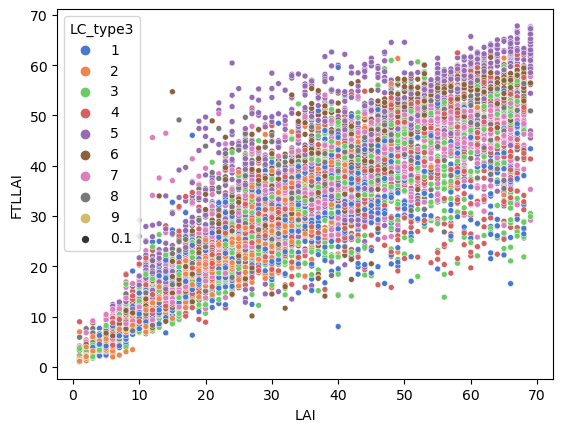

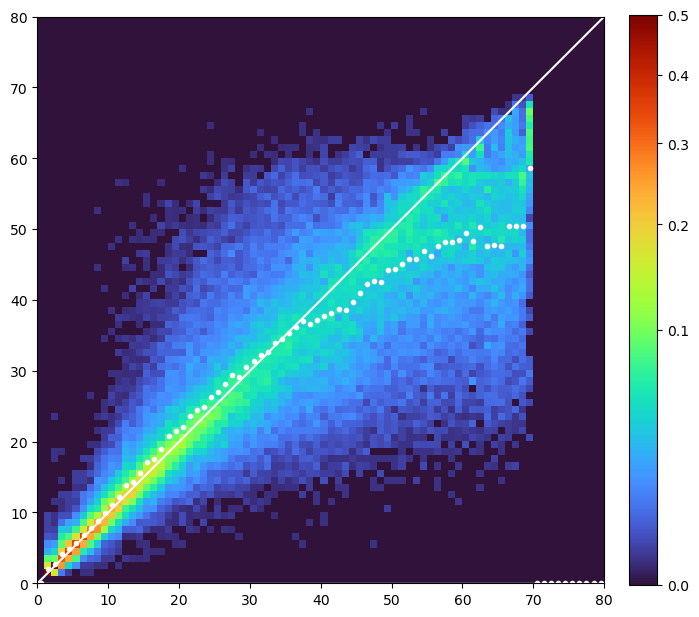

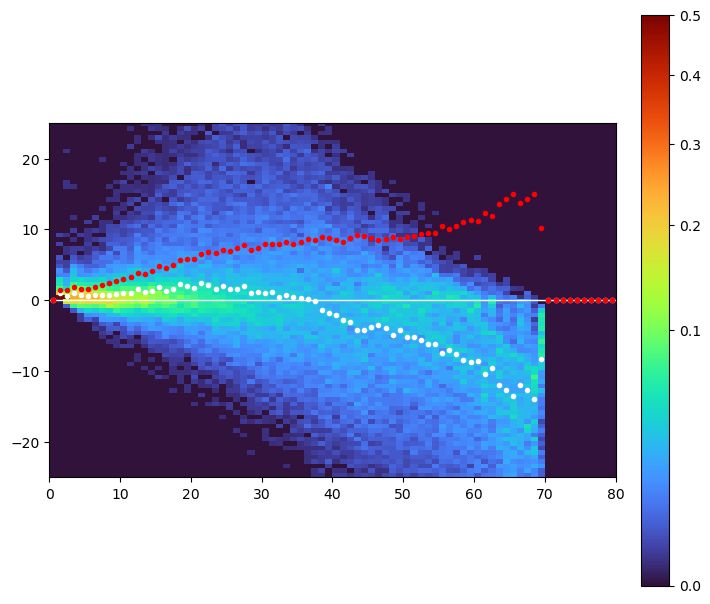

In [55]:
# FTL LAI
# try this with small RF and then uncomment out the 28-29 and comment line 25-26
method = 'FTL'

# response variable name
response = ['LAI']

# Regressor Names
# Names within scope of this script
regressorsNames = ['red','NIR','cosSZA','cosVZA','cosSA']
samplingFeatures = regressorsNames
# Names within scope of GEE
regressorsGEENames =  [ 'SR_B4', 'SR_B5','cosSZA','cosVZA','cosSA'] 
# Generic names we export RF with
regressors = ["x1","x2","x3","x4","x5"]

#Specify scaling and index for Domain, currently we only allow one digit per regressor
# Number of digits per regressor
domainIndex = [1,1,1,1,1]
# Sxaling per regressor
domainScaling = [ 10/10000, 10/10000,10/10000,10/10000,10/10000]
# Offset per regressor
domainOffset = [ 0,0,0,0,0]

# calbiomeDictLAIFTL= hierarchicalRF(calbiomeDictLAIFTL,calbiomeDictLAI,regressorsNames,regressorsGEENames, response, domainScaling,domainOffset, maxDepth=10, minSamplesSplit=11,\
#                              maxleafnodesParent=10,  minSamplesLeafParent=10,maxleafnodesChild= 999, minSamplesLeafChild=10,maxFeatures=5,nTrees = 10)

calbiomeDictLAIFTL= hierarchicalRF(calbiomeDictLAIFTL,calbiomeDictLAI,regressorsNames,regressorsGEENames, response, domainScaling,domainOffset, maxDepth=10, minSamplesSplit=11,\
                             maxleafnodesParent=999,  minSamplesLeafParent=10,maxleafnodesChild= 999, minSamplesLeafChild=10,maxFeatures=5,nTrees = 100)

calbiomeDictLAIFTL=  predictClassifier(calbiomeDictLAIFTL,calbiomeDictLAIFTL, 'FTL', regressorsNames, ['LAI'])
valbiomeDictLAI=  predictClassifier(valbiomeDictLAI,calbiomeDictLAIFTL, 'FTL', regressorsNames, ['LAI'])


method = 'FTL'
response = 'LAI'
valbiomeDFLAI = pd.DataFrame()
for LC_type3 in calbiomeDictLAI.keys():
    if ( LC_type3<10) :
        valbiomeDFLAI = pd.concat([valbiomeDFLAI,valbiomeDictLAI[LC_type3]['DF']])
sns.scatterplot(valbiomeDFLAI.sample(10000),x=response,y=method+response,hue='LC_type3',size=0.1,palette='muted')
plotHistResultsCond(valbiomeDFLAI,method+response,'LAI',datarange=[[0,80],[0,80]],nbins=80,gamma=0.5)
plotHistResidualsCond(valbiomeDFLAI,method+response,'LAI',datarange=[[0,80],[-25,25]],nbins=80,gamma=0.5)

In [56]:
print(calbiomeDictLAIFTL[1]['FTLLAIparentRFDict']['RF'])

RandomForestRegressor(bootstrap=False, max_depth=10, max_features=5,
                      max_leaf_nodes=999, min_samples_leaf=10,
                      min_samples_split=11, n_estimators=1, n_jobs=40,
                      random_state=0)


In [ ]:
# FTL FAPAR
method = 'FTL'

# response variable name
response = ['FAPAR']

# Regressor Names
# Names within scope of this script
regressorsNames = ['red','NIR','cosSZA','cosVZA','cosSA']
samplingFeatures = regressorsNames
# Names within scope of GEE
regressorsGEENames =  [ 'SR_B4', 'SR_B5','cosSZA','cosVZA','cosSA'] 
# Generic names we export RF with
regressors = ["x1","x2","x3","x4","x5"]

#Specify scaling and index for Domain, currently we only allow one digit per regressor
# Number of digits per regressor
domainIndex = [1,1,1,1,1]
# Sxaling per regressor
domainScaling = [ 10/10000, 10/10000,10/10000,10/10000,10/10000]
# Offset per regressor
domainOffset = [ 0,0,0,0,0]

calbiomeDictFAPARFTL= hierarchicalRF(calbiomeDictFAPARFTL,calbiomeDictLAI,regressorsNames,regressorsGEENames, response, domainScaling,domainOffset, maxDepth=10, minSamplesSplit=11,\
                             maxleafnodesParent=999 ,  minSamplesLeafParent=10,maxleafnodesChild= 999, minSamplesLeafChild=10,maxFeatures=5,nTrees = 100)


calbiomeDictFAPARFTL=  predictClassifier(calbiomeDictFAPARFTL,calbiomeDictFAPARFTL, 'FTL', regressorsNames, ['FAPAR'])
valbiomeDictFAPAR=  predictClassifier(valbiomeDictLAI,calbiomeDictFAPARFTL, 'FTL', regressorsNames, ['FAPAR'])


method = 'FTL'
response = 'FAPAR'
valbiomeDFFAPAR = pd.DataFrame()
for LC_type3 in calbiomeDictFAPAR.keys():
    if ( LC_type3<10) :
        valbiomeDFFAPAR = pd.concat([valbiomeDFFAPAR,valbiomeDictFAPAR[LC_type3]['DF']])
sns.scatterplot(valbiomeDFFAPAR.sample(10000),x=response,y=method+response,hue='LC_type3',size=0.1,palette='muted')
plotHistResultsCond(valbiomeDFFAPAR,method+response,'FAPAR',datarange=[[0,80],[0,80]],nbins=80,gamma=0.5)
plotHistResidualsCond(valbiomeDFFAPAR,method+response,'FAPAR',datarange=[[0,80],[-25,25]],nbins=80,gamma=0.5)

In [ ]:
# Cassidy - please make plots like fig 8 of K2021 but in stead of all and correctly classified series you will need a separate series for each method
# Once you make the plots for LAI repeat for FAPAR

In [16]:
ee.Authenticate()

Enter verification code:  4/1AWtgzh4Di0K1gLLLLMRXndnPNBBQHen1f_KMGZfXGv1HehXUtWmOWE75vzA



Successfully saved authorization token.


In [17]:
ee.Initialize()

In [18]:
print(geemap.ee_user_id() )

users/ccrs11fy2022li


In [190]:
# upload FTL classiers to gee as feature collections
reload(mlLocal)

method = 'FTL'

# response variable name
response = ['LAI']
targetDirectory = '/FTL_trees_LAI/'
methodDict = calbiomeDictLAIFTL

# Scaling and offset required of GEE regressors
regressorsGEECollectionName= "LANDSAT/LC08/C02/T1_L2"
regressorsGEEScaling = [2.75e-05,2.75e-05,1,1,1]
regressorsGEEOffset = [-0.02,-0.02,0,0,0]
regressorsGEEScaling2 = [10000,10000,1,1,1]


for biome in [1,2,3,4,5,6,7,8]:
    print('biome', biome)
    parentRFDict = methodDict[biome][method+response[0]+'parentRFDict']
    domain = parentRFDict['domain']
    trees = []
    trees.append(make_tree(parentRFDict['RF'][0],regressors,3))
    # print(trees[0])
    print('# of children', len(parentRFDict['childrenRFDict']))
    assetID = geemap.ee_user_id() + targetDirectory + method + 'biome' + str(biome) + 'parentRF' 
    mlLocal.export_trees_to_fc_CCRS(trees,response,regressors,regressorsGEECollectionName,regressorsGEENames,regressorsGEEScaling2,regressorsGEEScaling,regressorsGEEOffset,domain,domainScaling,domainOffset,assetID)
    # ml.export_trees_to_fc(trees,assetID)
    # ee_classifier = ml.strings_to_classifier(trees)
    # print(ee_classifier.getInfo())

    childSize = []
    for partition in parentRFDict['childrenRFDict'].keys():
        print('child #', partition)
        childRFDict = parentRFDict['childrenRFDict'][partition]
        childSize.append(childRFDict['size'])

        trees = []
        for tree in np.squeeze(childRFDict['RF'].estimators_) :
            # print('child tree',tree)
            trees.append(make_tree(tree,regressors,3))
        # print(trees)
        # trees = ml.rf_to_strings(estimator=childRFDict['RF'], feature_names=regressors,processes=36,output_mode='REGRESSION')
        assetID = geemap.ee_user_id() + targetDirectory + method + 'biome' + str(biome) + 'childRF' + str(int(partition*1000)) 
        domain = [0]
        domainScaling = [0]
        domainOffset = [0]
        mlLocal.export_trees_to_fc_CCRS(trees,response,regressors,regressorsGEECollectionName,regressorsGEENames,regressorsGEEScaling2,regressorsGEEScaling,regressorsGEEOffset,domain,domainScaling,domainOffset,assetID)
        # ml.export_trees_to_fc(trees,assetID)
        # ee_classifier = ml.strings_to_classifier(trees)
        # print(ee_classifier.getInfo())
    print(childSize)

biome 1
# of children 685
child # 1.081
child # 1.1


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 1.151
child # 1.161
child # 1.189
child # 1.222
child # 1.266
child # 1.312
child # 1.335
child # 1.342
child # 1.381
child # 1.385
child # 1.444
child # 1.481
child # 1.5
child # 1.503
child # 1.574
child # 1.576
child # 1.619
child # 1.642
child # 1.818
child # 1.833


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 1.867


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 1.941
child # 1.953
child # 1.985
child # 2.0
child # 2.021
child # 2.048
child # 2.052
child # 2.055
child # 2.077
child # 2.091
child # 2.1
child # 2.11
child # 2.147
child # 2.16
child # 2.197
child # 2.2


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 2.238
child # 2.248
child # 2.272
child # 2.316
child # 2.318
child # 2.333


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 2.342
child # 2.348
child # 2.364
child # 2.437
child # 2.5
child # 2.546
child # 2.556


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 2.599
child # 2.652
child # 2.688
child # 2.692
child # 2.7
child # 2.721
child # 2.753
child # 2.78
child # 2.786
child # 2.814
child # 2.867
child # 2.909
child # 2.952
child # 2.988
child # 3.0


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2


child # 3.049
child # 3.052
child # 3.076
child # 3.099
child # 3.152
child # 3.186
child # 3.222


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 3.229
child # 3.27
child # 3.299
child # 3.338
child # 3.455
child # 3.462
child # 3.5
child # 3.531
child # 3.583
child # 3.625
child # 3.666
child # 3.7


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 3.712
child # 3.733
child # 3.775
child # 3.8
child # 3.811
child # 3.838
child # 3.887
child # 3.889
child # 3.893
child # 3.923


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 3.938
child # 3.947
child # 3.957
child # 4.0
child # 4.067


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 4.079
child # 4.121
child # 4.125


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 4.127
child # 4.136
child # 4.141
child # 4.146
child # 4.154
child # 4.188


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 4.285
child # 4.308


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 4.357


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 4.429


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 4.441
child # 4.455
child # 4.463
child # 4.466
child # 4.5
child # 4.583


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 4.6
child # 4.611
child # 4.685
child # 4.72
child # 4.724
child # 4.758
child # 4.9
child # 4.921
child # 4.938


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 4.949
child # 4.957
child # 4.99
child # 5.031


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 5.089
child # 5.143
child # 5.25
child # 5.267


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 5.298
child # 5.333
child # 5.348
child # 5.384
child # 5.4
child # 5.427
child # 5.5
child # 5.538
child # 5.571


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 5.601
child # 5.618
child # 5.75


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 5.752
child # 5.797
child # 5.816
child # 5.818
child # 5.837
child # 5.846


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 5.93
child # 5.995
child # 6.022
child # 6.043
child # 6.076
child # 6.078
child # 6.115
child # 6.12
child # 6.129
child # 6.173
child # 6.182
child # 6.19
child # 6.297
child # 6.386
child # 6.417
child # 6.444
child # 6.455


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 6.491
child # 6.508
child # 6.529
child # 6.542
child # 6.571
child # 6.6
child # 6.727


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 6.75
child # 6.784
child # 6.8
child # 6.842
child # 6.846
child # 6.855
child # 6.875
child # 6.901
child # 6.911
child # 6.912
child # 6.933
child # 6.962


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 6.971
child # 7.0
child # 7.029
child # 7.091
child # 7.095
child # 7.109
child # 7.154


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 7.2
child # 7.259
child # 7.268
child # 7.273
child # 7.286
child # 7.333
child # 7.338
child # 7.385
child # 7.405
child # 7.412
child # 7.47
child # 7.488
child # 7.495
child # 7.5
child # 7.533
child # 7.583
child # 7.6
child # 7.608
child # 7.697
child # 7.717
child # 7.769
child # 7.782
child # 7.842
child # 7.867
child # 7.885


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 7.933
child # 7.955
child # 8.043
child # 8.061
child # 8.074
child # 8.1
child # 8.135
child # 8.143
child # 8.154


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 8.2


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 8.238
child # 8.273


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 8.286


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 8.3
child # 8.319
child # 8.444
child # 8.448
child # 8.498
child # 8.5
child # 8.538
child # 8.545


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 8.562
child # 8.615
child # 8.727
child # 8.733
child # 8.75
child # 8.765
child # 8.816
child # 8.909
child # 8.917
child # 9.0


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 9.011
child # 9.095
child # 9.1
child # 9.118
child # 9.123
child # 9.133
child # 9.136
child # 9.2
child # 9.226
child # 9.243
child # 9.288
child # 9.3
child # 9.331
child # 9.375
child # 9.391
child # 9.393
child # 9.4


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 9.406
child # 9.429
child # 9.464
child # 9.5
child # 9.526
child # 9.529


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 9.564
child # 9.6


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 9.647
child # 9.707
child # 9.769


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 9.789
child # 9.798
child # 9.8


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 9.836
child # 9.917
child # 9.936
child # 10.0
child # 10.08
child # 10.091
child # 10.11
child # 10.133
child # 10.141
child # 10.228
child # 10.311
child # 10.326
child # 10.4
child # 10.417
child # 10.429
child # 10.5
child # 10.528
child # 10.529
child # 10.583
child # 10.602
child # 10.632


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 10.717
child # 10.727
child # 10.789
child # 10.833


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 10.846
child # 10.9
child # 10.917


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 10.923
child # 10.935
child # 10.95
child # 11.0
child # 11.06
child # 11.077
child # 11.16
child # 11.174
child # 11.178
child # 11.217
child # 11.268
child # 11.269
child # 11.273
child # 11.35
child # 11.538
child # 11.545


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 11.548
child # 11.658
child # 11.704
child # 11.83
child # 11.88
child # 11.882
child # 11.955
child # 11.965
child # 11.975
child # 12.0
child # 12.071
child # 12.1
child # 12.159
child # 12.211


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 12.212
child # 12.304
child # 12.316
child # 12.323


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 12.333


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 12.364
child # 12.5
child # 12.517
child # 12.545
child # 12.58
child # 12.583
child # 12.6
child # 12.615
child # 12.679
child # 12.692
child # 12.782
child # 12.789
child # 12.849
child # 12.857
child # 12.864


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 12.902
child # 12.909
child # 12.92
child # 12.923
child # 13.0
child # 13.167
child # 13.2


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 13.206


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 13.227
child # 13.32
child # 13.329
child # 13.364


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 13.4


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 13.552
child # 13.592
child # 13.643
child # 13.667
child # 13.671
child # 13.692
child # 13.7
child # 13.71
child # 13.8
child # 13.809
child # 13.857


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 13.919
child # 14.029
child # 14.077
child # 14.286
child # 14.4
child # 14.426
child # 14.5
child # 14.529
child # 14.538
child # 14.596
child # 14.763
child # 14.789


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 14.833
child # 14.979
child # 14.98
child # 15.0
child # 15.062
child # 15.191
child # 15.231
child # 15.267
child # 15.273
child # 15.333
child # 15.355
child # 15.372


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 15.435
child # 15.459
child # 15.526
child # 15.642
child # 15.738
child # 15.75
child # 15.759
child # 15.8
child # 15.846
child # 15.867
child # 15.909
child # 16.048
child # 16.183
child # 16.2
child # 16.226
child # 16.273
child # 16.275
child # 16.4
child # 16.625
child # 16.643
child # 16.648
child # 16.706
child # 16.71
child # 16.727
child # 16.758
child # 16.767
child # 16.8
child # 16.885
child # 16.9
child # 16.955
child # 16.971


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 17.077


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 17.182
child # 17.2
child # 17.28
child # 17.3
child # 17.333
child # 17.414
child # 17.455
child # 17.5
child # 17.587
child # 17.652
child # 17.653
child # 17.684
child # 17.714
child # 17.75
child # 17.8
child # 17.955
child # 18.091
child # 18.17
child # 18.217
child # 18.389
child # 18.5
child # 18.542
child # 18.556
child # 18.56
child # 18.6
child # 18.746
child # 18.75
child # 18.762
child # 18.8
child # 18.805
child # 18.812
child # 18.909
child # 18.955
child # 19.0
child # 19.152
child # 19.167
child # 19.2
child # 19.268
child # 19.4
child # 19.438
child # 19.5
child # 19.615
child # 19.733


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 19.737
child # 19.834
child # 19.933


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 20.148
child # 20.153
child # 20.154


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2


child # 20.235
child # 20.373
child # 20.462
child # 20.5
child # 20.583
child # 20.6
child # 20.633


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 20.636
child # 20.667
child # 20.7
child # 20.75
child # 20.8
child # 20.802
child # 20.87
child # 21.059
child # 21.128
child # 21.171
child # 21.2
child # 21.204
child # 21.467
child # 21.522
child # 21.556
child # 21.7
child # 21.846
child # 21.9
child # 22.109
child # 22.4
child # 22.444


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2


child # 22.466
child # 22.556
child # 22.58
child # 22.583
child # 22.602
child # 22.643


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 22.826
child # 22.875
child # 22.917


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 23.138
child # 23.446


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2


child # 23.462
child # 23.675
child # 23.688
child # 23.737
child # 23.739


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2


child # 23.8
child # 24.036
child # 24.071
child # 24.167
child # 24.188


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2


child # 24.286
child # 24.4
child # 24.474
child # 24.8
child # 24.875


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 25.179
child # 25.398
child # 25.429


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 25.455


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 25.481
child # 25.527
child # 25.538


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 25.545
child # 25.643
child # 25.667
child # 25.675
child # 25.857
child # 25.956
child # 26.0
child # 26.1
child # 26.118
child # 26.4
child # 26.529
child # 26.6
child # 26.615
child # 26.727
child # 26.786
child # 26.833
child # 26.9


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 26.909
child # 27.0
child # 27.244
child # 27.308
child # 27.484
child # 27.5
child # 27.733
child # 27.75
child # 27.786
child # 27.9
child # 28.091


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 28.2
child # 28.629
child # 28.714
child # 29.0
child # 29.252
child # 29.467


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 29.545
child # 29.692
child # 29.857
child # 30.264
child # 30.333
child # 30.4


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 30.5
child # 30.678
child # 30.8


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 30.938
child # 30.963
child # 31.0
child # 31.1
child # 31.132
child # 31.158
child # 31.444
child # 31.612
child # 31.643
child # 32.0
child # 32.132
child # 32.162
child # 32.214


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 32.382
child # 32.385
child # 32.458
child # 32.467


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 32.8
child # 33.56
child # 33.562
child # 33.6
child # 33.7
child # 33.9


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 34.3
child # 34.312
child # 34.4
child # 34.812
child # 34.933


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 35.114
child # 35.263
child # 35.641
child # 35.664
child # 35.872
child # 35.893
child # 36.056
child # 36.533
child # 36.688
child # 37.182
child # 37.2
child # 37.231


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 37.25
child # 37.31
child # 37.318
child # 37.4
child # 37.556


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 37.762
child # 37.9


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 38.247
child # 38.5
child # 39.062


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 39.727
child # 40.0
child # 40.962
child # 41.892
child # 42.129
child # 42.923
child # 43.042
child # 43.2
child # 43.929
child # 44.143
child # 44.308


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 44.345
child # 44.625
child # 44.846
child # 45.0
child # 45.071
child # 45.333
child # 46.333


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 46.562
child # 47.222
child # 47.529


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 47.929
child # 47.952
child # 48.806
child # 49.269


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 49.842
child # 49.938
child # 50.4
child # 52.062
child # 52.583
child # 53.588
child # 54.579
child # 54.786
child # 56.179
child # 56.5


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2


child # 57.0


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 58.048
child # 60.5


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 63.476
[7134, 29, 4803, 4900, 352, 608, 12872, 1325, 4670, 4196, 1798, 25, 311, 395, 6850, 10437, 7424, 22262, 9970, 7451, 14, 35, 32, 8549, 42106, 30208, 1026, 18655, 13138, 55013, 10613, 406, 2265, 257, 1325, 10774, 8119, 53105, 61, 1888, 8507, 1806, 22751, 213, 50, 26155, 12830, 4866, 593, 113, 18119, 28, 31801, 638, 10101, 117, 21, 1055, 308, 6383, 14727, 6290, 438, 525, 6272, 674, 69, 25851, 4508, 18917, 17391, 8517, 26824, 42, 22823, 25898, 6409, 9269, 507, 4796, 8919, 71, 388, 351, 23864, 33, 3118, 139, 7785, 20, 918, 8021, 14666, 90, 2994, 36, 165, 17005, 242, 18, 30, 35415, 19814, 28, 6406, 2656, 9491, 656, 89, 62, 5746, 50, 49, 41, 8997, 11, 1927, 14106, 297, 40, 13, 500, 5594, 398, 5048, 16995, 22, 20974, 29, 7142, 325, 26265, 47, 10087, 970, 192, 40, 7018, 3062, 432, 1411, 23, 28378, 13, 12979, 52, 2594, 8019, 42, 33739, 268, 13973, 543, 21549, 37, 445, 1549, 3879, 2451, 2138, 9834, 316, 122, 7001, 1875, 126, 8645, 879, 2421, 12, 524, 34, 7829, 1901, 96, 102, 19, 27

C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 1.667
child # 1.731
child # 1.756
child # 1.786
child # 1.814
child # 1.833
child # 1.836
child # 1.882
child # 2.0
child # 2.029
child # 2.049
child # 2.059
child # 2.083
child # 2.1
child # 2.135
child # 2.143
child # 2.154
child # 2.179
child # 2.188
child # 2.211
child # 2.217
child # 2.25
child # 2.27
child # 2.275
child # 2.276
child # 2.282
child # 2.393
child # 2.437
child # 2.484
child # 2.5
child # 2.528
child # 2.534
child # 2.562
child # 2.625
child # 2.632
child # 2.692
child # 2.75


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 2.818
child # 2.824
child # 2.833
child # 2.875
child # 2.895
child # 2.899
child # 2.941
child # 3.0
child # 3.012
child # 3.067
child # 3.077
child # 3.136
child # 3.167
child # 3.2
child # 3.211


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 3.217
child # 3.242
child # 3.25
child # 3.292
child # 3.366
child # 3.4
child # 3.452
child # 3.471
child # 3.5
child # 3.545
child # 3.581
child # 3.611
child # 3.643
child # 3.727
child # 3.789


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 3.8


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 3.818
child # 3.909


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 3.917
child # 3.922
child # 3.929


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 4.0
child # 4.091
child # 4.1
child # 4.194
child # 4.238
child # 4.308
child # 4.417
child # 4.455
child # 4.5
child # 4.533
child # 4.593
child # 4.595
child # 4.636
child # 4.692
child # 4.76
child # 4.769
child # 4.778
child # 4.78
child # 4.8
child # 4.864
child # 4.88
child # 4.9
child # 4.902
child # 4.929
child # 4.96
child # 5.0
child # 5.167
child # 5.188
child # 5.2
child # 5.235
child # 5.263
child # 5.273


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 5.484
child # 5.559
child # 5.667
child # 5.712
child # 5.727
child # 5.77
child # 5.88
child # 6.0


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 6.029
child # 6.059
child # 6.083
child # 6.091
child # 6.1
child # 6.182
child # 6.2
child # 6.211
child # 6.25
child # 6.273
child # 6.288
child # 6.364
child # 6.485
child # 6.5


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 6.524
child # 6.533
child # 6.562
child # 6.565
child # 6.567
child # 6.6
child # 6.625
child # 6.7
child # 6.727
child # 6.76
child # 6.818
child # 6.857
child # 6.908
child # 6.933
child # 7.067


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 7.1
child # 7.182
child # 7.2


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 7.276
child # 7.294
child # 7.3
child # 7.312


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 7.4
child # 7.429
child # 7.462
child # 7.467
child # 7.588
child # 7.636


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 7.692
child # 7.727
child # 7.825
child # 7.87
child # 7.9
child # 7.931
child # 8.0
child # 8.071
child # 8.125
child # 8.167
child # 8.2
child # 8.4
child # 8.443
child # 8.571
child # 8.676
child # 8.727


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 8.739


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 8.75
child # 8.769
child # 8.818
child # 8.85
child # 8.88
child # 8.947


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 9.0
child # 9.095
child # 9.167
child # 9.2
child # 9.214
child # 9.286
child # 9.3
child # 9.375
child # 9.474
child # 9.725
child # 9.789
child # 9.8


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 9.9
child # 10.0
child # 10.065
child # 10.167
child # 10.183
child # 10.188
child # 10.2
child # 10.267


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 10.281
child # 10.3
child # 10.4
child # 10.412
child # 10.471
child # 10.538
child # 10.625
child # 10.636
child # 10.786


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 10.8
child # 10.812
child # 10.909
child # 10.938
child # 11.0
child # 11.071
child # 11.097
child # 11.143
child # 11.273
child # 11.357
child # 11.455
child # 11.7
child # 11.733
child # 11.818
child # 11.846
child # 11.867
child # 11.889
child # 11.9
child # 11.917
child # 12.0
child # 12.167
child # 12.333
child # 12.364
child # 12.6
child # 12.625
child # 12.769
child # 12.938


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 13.1
child # 13.105
child # 13.154
child # 13.182


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 13.254
child # 13.357
child # 13.364
child # 13.467
child # 13.6


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 13.75
child # 13.826
child # 13.944
child # 14.0
child # 14.077
child # 14.15
child # 14.2
child # 14.267
child # 14.286


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 14.5
child # 14.531
child # 14.684
child # 14.765
child # 14.812
child # 14.833


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 14.913


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 15.0
child # 15.083
child # 15.143
child # 15.167
child # 15.455
child # 15.5
child # 15.583
child # 15.765
child # 15.8
child # 15.811
child # 16.154
child # 16.273


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 16.5
child # 16.533
child # 16.632
child # 16.636
child # 16.667
child # 16.733
child # 16.75
child # 16.818
child # 16.846
child # 16.9
child # 16.909
child # 17.0


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 17.056
child # 17.286
child # 17.6
child # 17.667
child # 17.7
child # 17.786
child # 17.8
child # 17.889
child # 17.9
child # 18.0


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 18.412
child # 18.533
child # 18.538
child # 18.636
child # 18.7
child # 18.727
child # 18.818
child # 18.875
child # 18.9
child # 19.1
child # 19.133


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 19.2
child # 19.273
child # 19.857


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 20.1
child # 20.208
child # 20.312
child # 20.353
child # 20.647
child # 20.688
child # 20.8
child # 21.0
child # 21.049
child # 21.1
child # 21.2
child # 21.429


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 21.667
child # 22.053
child # 22.083
child # 22.421


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 22.818
child # 22.909
child # 23.071
child # 23.1


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 23.444
child # 23.455
child # 23.75
child # 24.333
child # 24.357


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 24.421


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2


child # 24.471
child # 24.88


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 25.0
child # 25.109
child # 25.733
child # 25.8
child # 27.364
child # 27.644
child # 28.3
child # 28.643
child # 28.824
child # 29.263
child # 29.5
child # 29.545
child # 29.9
child # 29.923
child # 30.9
child # 31.933
child # 32.8
child # 33.091
child # 33.1
child # 33.562
child # 35.5
child # 35.545
child # 36.385
child # 38.361
child # 38.6
child # 38.688
child # 39.0
child # 40.0
child # 41.364
child # 43.636
child # 46.3
child # 46.737


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 49.727
child # 49.733
child # 53.167
child # 56.353
[485, 770, 1352, 277, 272, 564, 107, 941, 806, 5484, 1567, 376, 44, 371, 546, 6394, 3427, 8757, 6984, 10036, 395, 339, 3216, 1926, 446, 285, 918, 53128, 257, 96, 10716, 1010, 796, 94, 175, 7230, 8866, 4042, 5300, 1463, 6882, 3313, 147, 307, 888, 8633, 714, 78, 153, 41, 1581, 1426, 2463, 966, 203, 6674, 2934, 1956, 3819, 1396, 26, 7652, 853, 1090, 48, 1429, 158, 539, 1397, 784, 385, 2033, 515, 1039, 291, 2087, 1800, 359, 4579, 30, 45, 87, 40, 247, 3082, 36, 1779, 89, 912, 290, 248, 174, 15, 1694, 83, 75, 3437, 6821, 2236, 268, 3292, 1375, 407, 2926, 78, 2463, 1612, 254, 386, 23, 1146, 1981, 204, 84, 1505, 136, 617, 34, 5155, 1485, 655, 773, 172, 2446, 3218, 38, 6529, 912, 2292, 69, 21, 141, 1117, 919, 142, 472, 289, 414, 339, 40, 893, 18, 2053, 748, 154, 508, 1708, 160, 134, 5329, 1287, 314, 3117, 1280, 38, 626, 555, 50, 2283, 111, 1842, 61, 908, 355, 1236, 78, 21, 32, 843, 364, 5702, 733, 223, 4521, 2141, 138, 75, 366, 26, 568

C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 2.364
child # 2.545
child # 2.615
child # 2.692
child # 2.717
child # 2.778
child # 2.812
child # 2.851
child # 2.867
child # 2.909
child # 3.0
child # 3.007
child # 3.2
child # 3.25
child # 3.4
child # 3.481
child # 3.615
child # 3.75
child # 3.9
child # 3.909
child # 4.0
child # 4.029
child # 4.031
child # 4.057
child # 4.214
child # 4.25
child # 4.318
child # 4.367
child # 4.436
child # 4.5
child # 4.545
child # 4.611
child # 4.615
child # 4.7
child # 4.9
child # 4.923
child # 4.942
child # 5.0
child # 5.125
child # 5.182
child # 5.267
child # 5.45
child # 5.5
child # 5.565
child # 5.583
child # 5.691
child # 5.692


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 5.722
child # 5.75
child # 5.789
child # 5.8
child # 5.929
child # 6.0
child # 6.077
child # 6.222


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 6.294
child # 6.353
child # 6.467
child # 6.5
child # 6.557
child # 6.7
child # 6.75
child # 6.833
child # 6.896
child # 6.9
child # 6.909
child # 6.958
child # 7.0
child # 7.056


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 7.12
child # 7.304
child # 7.314
child # 7.364
child # 7.4
child # 7.429
child # 7.438
child # 7.818
child # 7.857
child # 7.9
child # 7.923
child # 7.933
child # 7.947
child # 8.0
child # 8.077
child # 8.1
child # 8.167
child # 8.211
child # 8.357
child # 8.571
child # 8.663
child # 8.757
child # 8.833
child # 8.846


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 8.9


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 9.125
child # 9.2
child # 9.231
child # 9.333
child # 9.389
child # 9.571
child # 9.727
child # 9.895
child # 9.917
child # 10.0
child # 10.071
child # 10.17
child # 10.188
child # 10.2
child # 10.3
child # 10.4
child # 10.6
child # 10.87
child # 10.923
child # 11.3
child # 11.333
child # 11.4
child # 11.435
child # 11.579
child # 11.611
child # 11.8
child # 12.082
child # 12.118
child # 12.417


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 12.429
child # 12.6
child # 12.667
child # 12.714
child # 12.8
child # 12.848
child # 13.059
child # 13.125
child # 13.263
child # 13.278
child # 13.667
child # 13.8
child # 13.818
child # 13.923
child # 14.053
child # 14.067
child # 14.2
child # 14.305
child # 14.364
child # 14.385
child # 14.462
child # 14.471
child # 14.5
child # 14.538
child # 14.636
child # 14.667
child # 15.2
child # 15.214
child # 15.5
child # 15.786
child # 15.789
child # 15.9
child # 16.0
child # 16.182


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 16.364
child # 16.462
child # 16.583
child # 17.0
child # 17.048
child # 17.056
child # 17.2
child # 17.429
child # 17.5
child # 17.556
child # 17.9
child # 17.929
child # 17.947
child # 18.1
child # 18.111


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 18.133
child # 18.364
child # 18.5


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 18.857
child # 19.0
child # 19.444
child # 19.529
child # 19.7
child # 19.8
child # 20.235
child # 20.273


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2


child # 20.5
child # 20.538
child # 20.625
child # 21.0
child # 21.25
child # 21.938
child # 22.0


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 22.261
child # 22.8
child # 23.7
child # 23.8
child # 24.077
child # 24.278
child # 24.462
child # 24.7
child # 26.692
child # 27.385
child # 28.312
child # 28.545
child # 28.6
child # 29.1
child # 29.667
child # 30.462


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 31.353
child # 33.421
child # 34.4
child # 34.6


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 34.763
child # 35.0
child # 35.7
child # 38.273
child # 38.688
child # 41.267
child # 41.727
child # 43.231
child # 49.333
child # 55.462
[520, 160, 166, 154, 113, 845, 295, 582, 972, 1039, 121, 1141, 190, 29, 146, 20, 277, 440, 2101, 775, 480, 1980, 273, 1238, 693, 3651, 16, 1004, 833, 1187, 207, 388, 600, 210, 1196, 4415, 322, 73, 822, 802, 412, 850, 352, 985, 18, 394, 2330, 290, 479, 80, 6980, 600, 2125, 435, 490, 1242, 434, 8701, 273, 6374, 45, 341, 152, 147, 70, 251, 1457, 385, 44, 1848, 635, 349, 269, 5659, 833, 80, 328, 2454, 175, 1170, 250, 1046, 37, 172, 95, 5944, 994, 465, 1277, 1389, 14, 205, 743, 1326, 693, 742, 106, 264, 835, 19, 135, 217, 962, 5238, 4948, 24, 48, 49, 308, 1387, 1477, 4516, 1618, 409, 468, 917, 116, 22, 18, 514, 329, 2191, 150, 1964, 90, 517, 2200, 228, 2043, 726, 97, 1730, 274, 318, 7913, 173, 45, 2251, 207, 3756, 69, 102, 1124, 375, 319, 408, 2521, 72, 192, 122, 1724, 950, 2425, 2338, 862, 1114, 70, 2840, 1147, 2355, 158, 303, 446, 343, 1379, 267

C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2


child # 1.16
child # 1.25
child # 1.308


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 1.5
child # 1.52


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 1.705
child # 1.722
child # 1.727


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 1.8
child # 2.071


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 2.083
child # 2.167


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 2.235
child # 2.267


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 2.5
child # 2.6
child # 2.692
child # 2.737
child # 3.0
child # 3.071
child # 3.15
child # 3.286
child # 3.417
child # 3.625
child # 3.636
child # 3.722
child # 4.029
child # 4.077
child # 4.083
child # 4.118
child # 4.143
child # 4.357
child # 4.435


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 4.5
child # 4.517
child # 4.546
child # 4.727
child # 4.867


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 4.907
child # 4.953
child # 5.0
child # 5.071
child # 5.2
child # 5.385
child # 5.421
child # 5.467
child # 5.512
child # 5.7
child # 5.882
child # 6.0
child # 6.148
child # 6.182
child # 6.222
child # 6.258
child # 6.316
child # 6.333
child # 6.4
child # 6.429
child # 6.434
child # 6.564
child # 6.643
child # 6.724
child # 6.737
child # 6.8
child # 6.914
child # 6.957
child # 6.962
child # 7.0
child # 7.045
child # 7.062
child # 7.105
child # 7.353
child # 7.476
child # 7.5
child # 7.585
child # 7.679
child # 7.692
child # 7.727
child # 7.744
child # 7.786
child # 7.9
child # 7.904
child # 8.045
child # 8.077
child # 8.083
child # 8.264
child # 8.273
child # 8.325
child # 8.375
child # 8.438
child # 8.7
child # 8.708


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 8.838
child # 8.923
child # 9.0


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 9.071
child # 9.074
child # 9.1


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2


child # 9.182
child # 9.2
child # 9.273
child # 9.357
child # 9.529
child # 9.549
child # 9.727
child # 9.733
child # 9.8
child # 9.803
child # 9.9
child # 9.909
child # 9.939
child # 10.0
child # 10.091
child # 10.133
child # 10.455
child # 10.462
child # 10.5
child # 10.6
child # 10.658
child # 10.727
child # 10.733
child # 10.8
child # 10.846
child # 10.923
child # 11.0
child # 11.048
child # 11.062
child # 11.114
child # 11.2
child # 11.25
child # 11.294
child # 11.378
child # 11.4
child # 11.503
child # 11.565
child # 11.574
child # 11.68
child # 11.7
child # 11.748
child # 11.793
child # 11.945
child # 12.071
child # 12.3
child # 12.364
child # 12.429
child # 12.471
child # 12.481
child # 12.571
child # 12.6
child # 12.667
child # 12.688
child # 12.8
child # 12.9
child # 13.0
child # 13.059
child # 13.1
child # 13.176
child # 13.273
child # 13.429
child # 13.455
child # 13.474
child # 13.545
child # 13.6
child # 13.615
child # 13.636
child # 13.764
child # 13.9
child # 14.083
chi

C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 14.12
child # 14.158
child # 14.182
child # 14.2
child # 14.273
child # 14.385
child # 14.5
child # 14.588
child # 14.696
child # 14.75
child # 14.833
child # 14.846
child # 14.9
child # 14.941
child # 15.042
child # 15.128
child # 15.182
child # 15.288
child # 15.333
child # 15.358
child # 15.423
child # 15.5
child # 15.545
child # 15.727
child # 16.062
child # 16.077
child # 16.091
child # 16.3
child # 16.308
child # 16.353
child # 16.4
child # 16.458
child # 16.462
child # 16.529
child # 16.692
child # 16.952
child # 17.055
child # 17.1
child # 17.167
child # 17.276
child # 17.3
child # 17.333


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 17.409
child # 17.5
child # 17.6
child # 17.769
child # 17.8
child # 17.9
child # 18.125
child # 18.182
child # 18.467
child # 18.545
child # 18.6
child # 18.667
child # 18.786
child # 18.789
child # 19.0
child # 19.062
child # 19.12
child # 19.13
child # 19.167
child # 19.176
child # 19.2
child # 19.231
child # 19.273
child # 19.353
child # 19.421
child # 19.571
child # 19.583
child # 20.0
child # 20.083
child # 20.1


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 20.15
child # 20.16
child # 20.167
child # 20.182
child # 20.2
child # 20.636
child # 20.644
child # 20.692
child # 20.778
child # 21.0
child # 21.071
child # 21.083


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 21.167
child # 21.2
child # 21.296
child # 21.3
child # 21.306
child # 21.379
child # 21.6
child # 21.867
child # 21.917
child # 22.083
child # 22.231
child # 22.25
child # 22.3
child # 22.375
child # 22.389
child # 22.4
child # 22.467
child # 22.786


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 23.0
child # 23.231
child # 23.25
child # 23.4
child # 23.533
child # 23.545
child # 23.636
child # 24.091
child # 24.154
child # 24.188
child # 24.214
child # 24.294
child # 24.636
child # 24.882


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 25.129
child # 25.3
child # 25.308
child # 25.4
child # 25.5
child # 25.7
child # 25.8
child # 25.842
child # 26.1
child # 26.3
child # 26.4
child # 26.818
child # 27.267
child # 27.5
child # 27.556
child # 27.558
child # 27.722
child # 27.9
child # 28.062
child # 28.1


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 28.182
child # 28.222
child # 28.233
child # 28.3
child # 28.636
child # 28.8


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 28.9
child # 29.0
child # 29.2
child # 29.222
child # 29.471
child # 29.5


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 29.579
child # 29.625
child # 29.667
child # 29.929
child # 30.0
child # 30.176
child # 30.25


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 30.571
child # 30.6
child # 31.184
child # 31.9
child # 32.0
child # 32.071
child # 32.1
child # 32.2
child # 32.333
child # 32.364
child # 32.5
child # 32.714
child # 32.8
child # 32.818
child # 32.917
child # 33.8
child # 33.9
child # 33.917
child # 34.2
child # 34.353
child # 34.462
child # 34.833
child # 35.077
child # 35.455
child # 35.8
child # 36.1
child # 36.176
child # 36.316
child # 36.545
child # 36.571
child # 36.667
child # 36.8
child # 37.0
child # 37.3
child # 37.538
child # 37.6
child # 37.846
child # 38.0
child # 38.182
child # 38.412
child # 38.615


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 39.0
child # 39.2
child # 39.75


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 40.4
child # 41.529
child # 41.706
child # 41.857
child # 41.9
child # 41.929
child # 42.923
child # 43.167
child # 43.2
child # 43.4
child # 43.421
child # 43.455
child # 44.182


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 44.231
child # 44.3
child # 44.412
child # 45.0
child # 45.545
child # 46.238
child # 47.07
child # 47.571
child # 48.529
child # 49.071
child # 49.167
child # 49.4


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 49.8
child # 50.03
child # 50.462
child # 50.75
child # 51.947
child # 53.727
child # 53.923
child # 54.533
child # 54.615
child # 54.818
child # 56.545
child # 57.636


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 59.5
child # 61.0
[105, 102, 21, 30, 19, 42, 144, 26, 61, 18, 57, 671, 28, 17, 59, 1365, 21, 1076, 2406, 3116, 104, 365, 844, 851, 231, 146, 7681, 3644, 87, 12674, 1341, 420, 117, 52, 236, 1006, 19368, 2277, 29, 2726, 940, 3738, 2162, 3324, 100, 274, 1906, 9217, 692, 247, 11543, 3346, 3941, 663, 6886, 234, 1212, 8631, 479, 4930, 17568, 308, 184, 6487, 141, 6479, 2917, 451, 2678, 209, 3534, 657, 82, 509, 1146, 15866, 1346, 1763, 5259, 2388, 681, 1662, 32180, 2824, 6031, 6652, 2048, 2584, 13560, 1041, 8452, 475, 54, 6876, 4742, 45, 240, 12364, 66, 8494, 20, 1095, 3954, 1711, 12708, 2889, 4797, 1213, 3133, 959, 2963, 26489, 7089, 4237, 1904, 13877, 140, 4667, 351, 16656, 150, 582, 12462, 5449, 76, 3686, 4402, 972, 45381, 17, 3810, 11146, 713, 207, 4725, 8927, 4483, 355, 6597, 1384, 815, 3326, 7166, 6772, 368, 133, 1070, 438, 5149, 544, 1505, 973, 97, 4156, 24316, 647, 20, 113, 5082, 1558, 3056, 6589, 2578, 3574, 1240, 596, 8831, 575, 3005, 29, 101, 729, 193, 16556, 14132, 530, 277

C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 8.2


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 8.333


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 9.722
child # 10.6
child # 11.2
child # 11.3
child # 11.429
child # 11.588
child # 11.733


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2


child # 12.1


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 12.458
child # 12.909


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 13.0
child # 13.154


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 13.333
child # 13.8
child # 14.273
child # 14.6
child # 14.684
child # 14.882


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 15.0


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 15.034
child # 15.118
child # 15.467
child # 15.5
child # 16.0
child # 16.182
child # 16.3
child # 16.5


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 16.786
child # 16.909
child # 17.154
child # 17.25
child # 17.9
child # 18.083
child # 18.105
child # 18.286


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 18.294
child # 18.722
child # 19.0
child # 19.059
child # 19.333
child # 19.4
child # 19.65
child # 20.0
child # 20.083


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 20.2
child # 20.435
child # 20.571
child # 20.818
child # 20.882
child # 21.0
child # 21.429
child # 21.455
child # 21.526
child # 21.636
child # 21.71
child # 22.0
child # 22.4
child # 22.5
child # 22.933
child # 23.0
child # 23.85
child # 24.0
child # 24.263
child # 24.273
child # 24.727
child # 24.786
child # 25.0
child # 25.182
child # 25.258
child # 25.6


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 26.167


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 26.4


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 26.429
child # 26.667


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 26.929
child # 27.444
child # 27.538
child # 27.727
child # 27.833
child # 28.462
child # 28.944
child # 29.091
child # 29.1
child # 29.625
child # 29.7
child # 29.769
child # 29.944
child # 30.182
child # 30.389
child # 30.538
child # 30.733
child # 31.111
child # 31.455
child # 31.833
child # 31.875
child # 31.882
child # 32.467


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 32.5
child # 32.727
child # 34.167
child # 34.294
child # 34.333
child # 34.706
child # 35.143
child # 35.3


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 35.455
child # 35.474
child # 35.545
child # 35.7


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 35.733
child # 35.765
child # 36.0


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 36.2


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 36.357
child # 36.462
child # 36.786
child # 36.9


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 37.0
child # 37.571
child # 37.688
child # 37.8
child # 38.25
child # 38.5
child # 40.0
child # 40.059
child # 40.273
child # 40.655
child # 40.733
child # 41.071
child # 41.5
child # 41.522
child # 42.0
child # 42.083


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 42.462


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 42.562
child # 42.6
child # 42.769
child # 43.385


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 43.438


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 43.583


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 43.688


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 43.765
child # 43.8
child # 44.071
child # 44.636
child # 44.857


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 45.3
child # 45.684
child # 45.818
child # 46.167


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 46.25


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 46.273
child # 46.6
child # 46.615
child # 46.769
child # 47.1


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 47.4
child # 47.58
child # 47.667
child # 48.5
child # 48.9
child # 49.263
child # 49.319
child # 49.75
child # 49.933
child # 50.833


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2


child # 50.9


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 51.08
child # 51.107
child # 51.167
child # 51.5
child # 51.8
child # 51.818
child # 51.833
child # 51.941
child # 52.077
child # 52.083


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 52.2
child # 53.25
child # 53.909
child # 54.333


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 54.5
child # 54.627
child # 54.769


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 55.8
child # 55.874
child # 55.909
child # 56.2
child # 56.6
child # 56.694
child # 56.722
child # 56.75
child # 56.8


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 57.278
child # 57.478
child # 57.569
child # 58.036
child # 58.417
child # 58.7
child # 58.917
child # 58.933
child # 59.118
child # 59.25
child # 59.545
child # 60.237
child # 60.491
child # 60.615


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 61.0
child # 61.182
child # 61.297
child # 61.6
child # 61.9


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 62.0
child # 62.084
child # 62.13
child # 62.222
child # 62.818
child # 63.308
child # 63.545
child # 63.733
child # 64.091
child # 64.4
child # 64.6
child # 65.564
child # 65.933
child # 65.941


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2


child # 67.545
[55, 31, 42, 108, 21, 170, 17, 124, 148, 67, 36, 246, 31, 444, 45, 243, 71, 184, 91, 211, 44, 56, 1592, 413, 172, 86, 136, 22, 344, 56, 257, 155, 1239, 301, 143, 187, 281, 42, 118, 567, 373, 227, 491, 157, 229, 1126, 37, 278, 323, 88, 110, 105, 334, 181, 89, 107, 500, 795, 457, 898, 367, 343, 386, 281, 418, 99, 210, 919, 704, 161, 360, 1210, 55, 50, 35, 820, 33, 264, 123, 224, 91, 415, 23, 259, 642, 12, 528, 276, 26, 23, 122, 283, 230, 423, 466, 1118, 23, 956, 78, 27, 112, 66, 93, 1279, 276, 768, 166, 31, 469, 677, 406, 55, 800, 1024, 58, 58, 377, 179, 104, 29, 217, 695, 86, 276, 210, 964, 598, 867, 77, 300, 84, 223, 952, 1862, 316, 53, 27, 307, 515, 494, 53, 43, 50, 27, 125, 259, 96, 3375, 51, 302, 494, 81, 52, 39, 430, 221, 89, 535, 41, 659, 2419, 140, 376, 979, 80, 1290, 304, 401, 67, 44, 9262, 4191, 111, 422, 126, 235, 343, 596, 1097, 46, 1151, 113, 238, 59, 923, 9743, 39, 273, 12432, 90, 157, 111, 803, 2054, 399, 47, 128, 868, 851, 52498, 748, 248, 502, 181, 179, 10

C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 3.833
child # 4.083
child # 4.2
child # 4.417


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 4.833
child # 4.846
child # 4.889
child # 4.931
child # 5.0
child # 5.067
child # 5.19
child # 5.25
child # 5.467
child # 5.5
child # 5.545
child # 5.75


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 5.786
child # 5.8
child # 5.938


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 6.091
child # 6.133


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 6.2
child # 6.273
child # 6.3
child # 6.333
child # 6.364
child # 6.5
child # 6.6
child # 6.611
child # 6.733
child # 6.75
child # 6.8
child # 6.853
child # 6.882
child # 6.9
child # 7.0
child # 7.1
child # 7.2
child # 7.211
child # 7.417
child # 7.429
child # 7.438
child # 7.571
child # 7.667
child # 7.727
child # 7.75
child # 7.767
child # 8.0
child # 8.1
child # 8.167
child # 8.176
child # 8.188
child # 8.235
child # 8.25
child # 8.267


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 8.278
child # 8.3


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 8.4
child # 8.6
child # 8.636
child # 8.7
child # 8.786
child # 8.8
child # 8.806
child # 8.867
child # 8.9
child # 9.0
child # 9.1


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 9.231
child # 9.393
child # 9.4
child # 9.727
child # 9.75
child # 9.917
child # 10.0
child # 10.276
child # 10.357
child # 10.364
child # 10.4
child # 10.417
child # 10.455
child # 10.6
child # 10.667
child # 10.71
child # 10.923
child # 11.067
child # 11.2
child # 11.214
child # 11.25
child # 11.3
child # 11.333
child # 11.4
child # 11.462
child # 11.5
child # 11.6
child # 11.667
child # 11.786
child # 11.846


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 11.9
child # 11.929
child # 12.0
child # 12.071
child # 12.091
child # 12.182
child # 12.3
child # 12.308
child # 12.312
child # 12.333
child # 12.4
child # 12.818
child # 12.9
child # 13.083
child # 13.429
child # 13.438
child # 13.5
child # 13.692
child # 13.769
child # 13.882
child # 13.9
child # 14.364
child # 14.385
child # 14.5
child # 14.533
child # 14.6
child # 14.667
child # 14.8
child # 15.0
child # 15.231
child # 15.25
child # 15.294
child # 15.462
child # 15.643
child # 15.818
child # 15.933
child # 16.0
child # 16.471
child # 16.6
child # 16.625
child # 16.688
child # 16.871
child # 17.278
child # 17.444
child # 17.455
child # 18.1
child # 18.2
child # 18.364


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 18.5
child # 18.8
child # 19.1
child # 19.467
child # 19.5
child # 19.615
child # 19.7
child # 19.857
child # 20.167
child # 20.9
child # 21.2
child # 21.286
child # 21.385
child # 21.7
child # 21.909
child # 22.083
child # 22.333
child # 22.857
child # 23.176
child # 24.071
child # 24.1
child # 24.167
child # 24.9
child # 24.941
child # 25.278
child # 25.583
child # 26.1
child # 26.667
child # 27.0
child # 27.875
child # 28.1
child # 28.167
child # 28.3
child # 28.455
child # 28.7
child # 29.0
child # 29.167
child # 30.2


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 30.231
child # 31.5
child # 32.0
child # 32.5
child # 32.857
child # 32.889
child # 33.417
child # 34.0
child # 34.357
child # 34.7
child # 35.083
child # 35.2
child # 35.353
child # 36.368
child # 36.706
child # 38.75
child # 38.867
child # 39.0
child # 39.133
child # 39.545
child # 40.312
child # 40.455
child # 40.857
child # 41.1
child # 41.364
child # 42.333
child # 43.273
child # 43.278
child # 43.438
child # 43.474
child # 43.636
child # 44.0
child # 44.1
child # 44.6
child # 44.909
child # 45.3
child # 45.6
child # 46.316
child # 46.357
child # 46.692
child # 47.0
child # 47.474
child # 47.5
child # 48.846
child # 49.0
child # 49.333
child # 49.727
child # 49.833
child # 49.846
child # 50.333
child # 50.429
child # 51.091
child # 51.167
child # 51.391
child # 51.717
child # 52.552
child # 52.7
child # 53.4
child # 53.538
child # 54.545
child # 54.667
child # 55.182
child # 55.25
child # 56.582
child # 56.75
child # 57.2
child # 58.462
child # 58.692
child # 59.615
child 

C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 3.417
child # 4.133
child # 4.75


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 4.909
child # 5.3


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 6.364
child # 6.684
child # 7.077


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 7.1
child # 7.2
child # 7.273
child # 7.444


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 7.5
child # 8.067
child # 8.571
child # 8.692
child # 8.7
child # 9.0
child # 9.056
child # 9.091
child # 9.455
child # 10.167
child # 10.3
child # 10.6
child # 10.735
child # 10.8
child # 11.0
child # 11.083
child # 11.2
child # 11.6
child # 11.9
child # 12.1
child # 12.353
child # 12.4
child # 12.5
child # 12.545
child # 12.786
child # 12.8
child # 12.812
child # 12.846
child # 12.909
child # 13.091
child # 13.556
child # 13.6
child # 14.0
child # 14.35
child # 14.5
child # 14.545
child # 14.9
child # 15.0


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 15.188
child # 15.231
child # 15.353
child # 15.6
child # 15.636
child # 15.75
child # 15.846
child # 16.0


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2


child # 16.4
child # 16.5
child # 16.818
child # 16.9
child # 17.088
child # 17.1
child # 17.462


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 17.545
child # 17.667
child # 17.8
child # 18.0
child # 18.143
child # 18.273
child # 18.312
child # 18.391
child # 18.5
child # 18.688
child # 18.8
child # 19.077
child # 19.2
child # 19.278
child # 19.598
child # 19.6
child # 19.7
child # 19.909
child # 20.1


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 20.407
child # 20.8


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 20.909
child # 21.5
child # 21.7
child # 21.8
child # 21.846
child # 22.0
child # 22.4


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 22.6
child # 22.914
child # 23.0
child # 23.133
child # 23.25
child # 23.615
child # 23.7
child # 24.182
child # 24.4
child # 24.5
child # 24.636
child # 24.867
child # 25.182
child # 25.684
child # 25.7
child # 25.8
child # 25.857
child # 26.111
child # 26.214
child # 26.467
child # 26.5
child # 27.091
child # 27.269
child # 27.3
child # 27.545
child # 27.615


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 28.1
child # 28.5
child # 28.933
child # 29.364
child # 30.25
child # 30.75
child # 31.077
child # 31.091
child # 31.733
child # 31.846
child # 32.0


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 32.077
child # 32.1
child # 32.417
child # 32.5
child # 32.882
child # 32.933
child # 33.0
child # 33.067


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 33.417
child # 33.565
child # 33.733
child # 34.222
child # 34.3
child # 34.692
child # 35.0
child # 35.3
child # 35.417
child # 35.611
child # 35.8
child # 36.4
child # 36.5


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 36.7
child # 37.2
child # 37.263
child # 37.727
child # 37.9
child # 38.0
child # 38.083
child # 38.4


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 38.812
child # 39.056
child # 39.182
child # 39.2
child # 39.267
child # 40.083
child # 40.733
child # 41.154
child # 41.455
child # 41.714


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 41.818
child # 41.923
child # 42.107
child # 42.667
child # 42.8
child # 42.852
child # 43.4
child # 43.765
child # 44.0
child # 44.533
child # 44.538
child # 44.75
child # 44.923
child # 45.0
child # 46.188
child # 46.304
child # 47.562
child # 48.857
child # 50.133
child # 50.375
child # 50.467
child # 51.1


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 51.615
child # 51.917
child # 52.226
child # 52.917


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 53.3
child # 54.789
child # 55.0
child # 57.462
[19, 29, 16, 22, 51, 23, 49, 16, 783, 58, 629, 201, 641, 56, 204, 676, 527, 196, 472, 3026, 4874, 521, 654, 21, 1392, 12, 768, 793, 556, 657, 1783, 1194, 1211, 133, 2111, 586, 582, 74, 1223, 309, 977, 744, 390, 1191, 1774, 167, 4789, 1517, 3722, 2588, 2159, 50, 128, 2446, 5467, 1234, 223, 151, 4289, 64, 522, 4594, 3834, 2203, 225, 442, 35, 3011, 1766, 1581, 621, 650, 87, 521, 84, 2562, 77, 1310, 1173, 475, 1112, 537, 348, 3781, 78, 29, 170, 27, 1719, 2002, 4718, 3155, 87, 1413, 47, 173, 1919, 2602, 10329, 7692, 3237, 5155, 153, 320, 20, 760, 18, 2704, 5249, 2219, 598, 2221, 221, 3228, 95, 315, 3025, 5493, 1471, 1816, 52, 3837, 5311, 86, 5279, 4845, 193, 830, 309, 6547, 5761, 44, 178, 2517, 1520, 3662, 247, 256, 115, 57, 854, 2259, 619, 3656, 186, 6729, 664, 3635, 125, 4360, 5846, 3224, 49, 4801, 672, 7321, 7679, 108, 1020, 4323, 29, 479, 11007, 74, 364, 1168, 246, 972, 7946, 268, 29, 15, 69, 3213, 90, 3370, 2494, 1964, 4497, 90, 2

C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 4.471
child # 4.529


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2


child # 4.615
child # 4.733
child # 4.846


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 5.0
child # 5.1


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2


child # 5.455


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 5.533
child # 5.583


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 5.615
child # 5.7


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 5.75
child # 5.818


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 5.889
child # 5.929


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 5.947
child # 5.955
child # 6.0
child # 6.062
child # 6.083


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 6.1
child # 6.294
child # 6.333
child # 6.4
child # 6.417
child # 6.571
child # 6.583


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 6.75


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 6.8


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 6.833


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 6.867
child # 6.9
child # 6.923
child # 7.0
child # 7.069
child # 7.071


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 7.133


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 7.143
child # 7.148


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 7.3
child # 7.412
child # 7.438
child # 7.444
child # 7.449
child # 7.462
child # 7.5
child # 7.692
child # 7.727
child # 7.786


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 7.793
child # 7.818
child # 7.917


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 8.0
child # 8.2


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 8.3
child # 8.333
child # 8.353
child # 8.385
child # 8.4


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 8.5
child # 8.545
child # 8.667
child # 8.769


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 8.875
child # 8.917
child # 9.053
child # 9.062
child # 9.1
child # 9.278


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 9.3
child # 9.368
child # 9.4
child # 9.438
child # 9.5
child # 9.6
child # 9.8
child # 9.824
child # 9.857
child # 10.0
child # 10.053
child # 10.1
child # 10.2
child # 10.294
child # 10.9
child # 11.0
child # 11.071
child # 11.083
child # 11.3
child # 11.417
child # 11.514
child # 11.7
child # 12.0
child # 12.067
child # 12.1


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 12.3
child # 12.529
child # 12.833
child # 12.9
child # 13.167


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 13.25
child # 13.375
child # 13.4
child # 13.478
child # 13.583
child # 13.938
child # 13.957
child # 14.0
child # 14.8
child # 15.167
child # 15.667
child # 16.273
child # 16.3
child # 16.545
child # 16.909
child # 17.0
child # 17.5
child # 17.812
child # 17.875
child # 18.538
child # 18.75
child # 18.867
child # 19.083
child # 19.8
child # 20.0


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 20.279
child # 20.5
child # 20.667
child # 21.133
child # 21.8
child # 22.111
child # 22.442
child # 22.5
child # 22.9
child # 23.316
child # 23.9
child # 24.0
child # 24.182
child # 24.385
child # 24.583
child # 25.0
child # 25.091
child # 25.124
child # 25.917
child # 26.136
child # 26.273
child # 26.286
child # 26.9
child # 27.636
child # 28.133
child # 28.3
child # 28.9
child # 28.917
child # 29.167
child # 29.462
child # 29.632
child # 29.7
child # 29.786
child # 29.9
child # 29.929
child # 30.143
child # 30.308
child # 30.364
child # 30.545
child # 31.455
child # 31.917


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 32.3
child # 32.4
child # 32.692
child # 32.909
child # 33.2
child # 33.318
child # 34.455
child # 34.857
child # 35.0
child # 35.091
child # 35.1
child # 35.286
child # 35.643
child # 36.273
child # 36.471
child # 37.0
child # 37.167
child # 37.733
child # 37.8
child # 38.017
child # 38.846
child # 39.0
child # 39.056
child # 39.091
child # 39.1
child # 39.111
child # 39.182
child # 39.722
child # 39.75
child # 40.182
child # 40.545
child # 41.783
child # 42.4
child # 42.58


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 43.0
child # 43.143
child # 43.941
child # 44.0
child # 44.286
child # 44.579
child # 45.3
child # 45.364
child # 45.545
child # 45.923
child # 46.0


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 46.194
child # 46.263
child # 46.5
child # 47.158
child # 47.364
child # 47.409
child # 47.467
child # 47.471
child # 47.692
child # 47.947
child # 48.692
child # 48.812
child # 49.636
child # 49.895
child # 49.962
child # 50.029
child # 50.1
child # 50.333
child # 51.333
child # 51.429


C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
C:\Users\casli\AppData\Local\Temp\ipykernel_28212\2697052794.py:44: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of alway

child # 53.214
child # 54.1
child # 54.593
child # 54.69
child # 55.5
[23, 49, 105, 65, 16, 142, 51, 106, 63, 55, 79, 33, 93, 40, 20, 53, 263, 28, 26, 115, 176, 192, 50, 108, 201, 112, 159, 12, 195, 42, 48, 44, 42, 73, 76, 202, 237, 123, 34, 29, 114, 41, 187, 108, 131, 216, 160, 81, 317, 90, 66, 57, 167, 220, 59, 400, 59, 10, 121, 204, 99, 62, 256, 241, 557, 52, 158, 79, 108, 19, 121, 63, 174, 213, 157, 74, 168, 151, 168, 169, 148, 76, 261, 77, 10, 153, 248, 105, 14, 12, 155, 120, 302, 104, 589, 22, 58, 100, 102, 320, 271, 50, 515, 16, 11, 26, 72, 139, 23, 195, 147, 212, 201, 22, 198, 206, 26, 101, 218, 220, 457, 174, 118, 372, 399, 130, 31, 2983, 267, 15, 269, 151, 302, 124, 380, 570, 535, 131, 83, 182, 467, 424, 267, 263, 2634, 12, 782, 975, 275, 10, 192, 25, 395, 393, 276, 147, 212, 521, 81, 406, 383, 258, 309, 80, 525, 287, 337, 53, 183, 490, 581, 117, 299, 379, 303, 14, 317, 159, 308, 489, 483, 210, 374, 193, 307, 399, 167, 1755, 264, 562, 450, 220, 376, 18, 292, 288, 726, 11, 142

In [61]:
# first get the output in sckitlearn text format in a dataframe
partitionList = list(parentRFDict['childrenRFDict'].keys())
partition = partitionList[1]
childRFDict = parentRFDict['childrenRFDict'][partition]
print('child #', partition)

tree = childRFDict['RF'].estimators_[1]
print('child tree',tree)
            

rf = tree
r = export_text(rf,feature_names=regressors,show_weights=True,decimals=3)
r = r.splitlines()
rdf = pd.DataFrame(r,columns = ['rule'])

print('rdf',rdf)

child # 1.1
child tree DecisionTreeRegressor(max_depth=9, max_features=5, max_leaf_nodes=999,
                      min_samples_leaf=10, random_state=398764591)
rdf                   rule
0  |--- value: [1.862]


In [185]:
# first get the output in sckitlearn text format in a dataframe
partitionList = list(parentRFDict['childrenRFDict'].keys())
partition = partitionList[1]
childRFDict = parentRFDict['childrenRFDict'][partition]
print('child #', partition)

tree = childRFDict['RF'].estimators_[1]
print('child tree',tree)
            

rf = tree
# r = export_text(rf,feature_names=regressors,show_weights=True,decimals=3)
# r = r.splitlines()
# rdf = pd.DataFrame(r,columns = ['rule'])

temp = make_tree(rf, regressors, 3)

print(temp)

child # 1.1
child tree DecisionTreeRegressor(max_depth=9, max_features=5, max_leaf_nodes=999,
                      min_samples_leaf=10, random_state=398764591)
1) root 1 1 1 (1)
  2) x1 <= 0.000 0 0 1.862 *
  3) x1 >  0.000 0 0 1.862 *



In [186]:
# first get the output in sckitlearn text format in a dataframe
partitionList = list(parentRFDict['childrenRFDict'].keys())
partition = partitionList[2]
childRFDict = parentRFDict['childrenRFDict'][partition]
print('child #', partition)

tree = childRFDict['RF'].estimators_[1]
print('child tree',tree)
            

rf = tree
# r = export_text(rf,feature_names=regressors,show_weights=True,decimals=3)
# r = r.splitlines()
# rdf = pd.DataFrame(r,columns = ['rule'])

temp = make_tree(rf, regressors, 3)

print(temp)

child # 1.151
child tree DecisionTreeRegressor(max_depth=9, max_features=5, max_leaf_nodes=999,
                      min_samples_leaf=10, random_state=398764591)
1) root 1 1 1 (1)
  2) x3 <= 5947.500 0 0 1.000  
    4) x1 <= 1005.000 0 0 1.000  
      8) x2 <= 1525.000 0 0 1.000  
        16) x2 <= 1495.000 0 0 1.000  
          32) x3 <= 5806.000 0 0 1.000  
            64) x5 <= 6097.000 0 0 1.000  
              128) x1 <= 985.000 0 0 1.000  
                256) x2 <= 1405.000 0 0 1.000  
                  512) x2 <= 1375.000 0 0 1.000 *
                  513) x2 >  1375.000 0 0 1.182 *
                257) x2 >  1405.000 0 0 1.000 *
              129) x1 >  985.000 0 0 1.000 *
            65) x5 >  6097.000 0 0 1.056 *
          33) x3 >  5806.000 0 0 1.278  
            66) x5 <= 6130.500 0 0 1.278 *
            67) x5 >  6130.500 0 0 1.000 *
        17) x2 >  1495.000 0 0 1.000  
          34) x5 <= 5832.500 0 0 1.000  
            68) x4 <= 9980.500 0 0 1.000  
              1